In [1]:
# %matplotlib ipympl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
#from matplotlib.animation import FuncAnimation

The dynamic equation modeling the firing rate of V1 neurons as function of $\theta$ is: \
$\tau \frac{dr(\theta)}{dt} = -r(\theta)+F(I(\theta)) $ \
where, F(I) is a rectifier, suppressing negative values, i.e. F(I) = I for I > 0 and F(I) = 0, otherwise \
The dynamical equation can be solved using Euler's method as: \
$\tau \frac{r(\theta, t+1)-r(\theta, t)}{\Delta t} = -r(\theta, t)+F(I(\theta, t)) $ \
$\therefore r(\theta, t+1) = r(\theta, t)+\frac{\Delta t}{\tau}(-r(\theta, t)+F(I(\theta, t))) $ \
The input function is a combination of thalamic input and a recurrent input and is given by: \
$I(\theta) = h(\theta)+ \int_{-\pi/2}^{\pi/2} \frac{d\theta^{'}}{\pi} (J_0+J_2 cos(2(\theta-\theta^{'})))r(\theta^{'}) $ \
The thalamic input given by $h(\theta) $ is indpendent of time and is given using the formula: \
$h(\theta) = Ac(1-\epsilon + \epsilon cos(2(\theta - \theta_{cue}))) $ \
For the purposes of this assignment, $\theta_{cue} $ is set to 0, this merely determines the preferred orientation. The simulation was run for other $\theta_{cue} $ and no qualitative change in results were observed. \
Also, since $h(\theta) $ is independent of time, it can be computed once for each contrast value (c). \
The recurrent input can be implemented algorithmically by approximating the integratal as sum of infinitesimal $\Delta \theta $ \
In this limiting case, the second term becomes: \
$\int_{-\pi/2}^{\pi/2} \frac{d\theta^{'}}{\pi} (J_0+J_2 cos(2(\theta-\theta^{'})))r(\theta^{'}) = \sum_{-\pi/2}^{\pi/2} \frac{\Delta \theta}{\pi} (J_0+J_2 cos(2(\theta-\theta^{'})))r(\theta^{'}) $ \
$\therefore \int_{-\pi/2}^{\pi/2} \frac{d\theta^{'}}{\pi} (J_0+J_2 cos(2(\theta-\theta^{'})))r(\theta^{'}) = \frac{(\pi/2 - (-\pi/2)/len(\theta))}{\pi} \sum_{-\pi/2}^{\pi/2}  (J_0+J_2 cos(2(\theta-\theta^{'})))r(\theta^{'}) $ \
$\therefore \int_{-\pi/2}^{\pi/2} \frac{d\theta^{'}}{\pi} (J_0+J_2 cos(2(\theta-\theta^{'})))r(\theta^{'}) = \frac{1}{len(\theta)} \sum_{-\pi/2}^{\pi/2}  (J_0+J_2 cos(2(\theta-\theta^{'})))r(\theta^{'}) $ \
Now the first term in the sum is again independent of time and can be pre-computed, the sum can then be implemented as a matrix multiplication.

In [2]:
# Initializing constants
tau = 10 # ms
del_t = 1 # ms
T_max = 2000 # ms
T = np.arange(0, T_max, del_t)
num_neurons = 50
theta = np.linspace(-np.pi/2, np.pi/2, num_neurons)
A = 40/1000 # cycles/ms
contrasts = [0.1, 0.2, 0.4, 0.8]
theta_cue = 0
theta_cue_idx = abs(theta - theta_cue).argmin()


In [3]:
def F(I_in):
    # rectifying function that suppresses negative values
    if I_in < 0:
        I_out = 0
    else:
        I_out = I_in
    return I_out

def h(A, c, eps, theta, theta_cue):
    # computing thalamic input that is independent of time
    output = np.zeros(len(theta),)
    for ii in range(len(theta)):
        output[ii] = A*c*(1-eps+eps*np.cos(2*(theta[ii]-theta_cue)))
    return output

def recurrent_input(theta, J0, J2):
    # Computing the time-independent part of the recurrent input
    def f(ii, jj):
        return (J0 + J2 * np.cos(2* (theta[ii] - theta[jj])))
    val = np.zeros((len(theta),len(theta)))
    for ii in range(len(theta)):
        for jj in range(len(theta)):
            val[ii, jj] = f(ii, jj)
    return val

def firing_rate(theta, theta_0, T, tau, del_t, a, h_theta, second_term, noisy, noisiness):
    # Dynamic equation computing firing rate. Firing rate is initialized as a slightly-tuned function.
    # And is then updated over time by taking into account both the thalamic input and the recurrent activations.
    # The choice of thalamic input to be given by h(theta) or with a slightly noisy input is determined by the
    # parameter "noisy". The steady-state is determined if the change in firing-rate is less than a certain threshold,
    # in this case, the threshold is set to 1e-5
    r = np.zeros((len(theta),len(T)))
    for tt in range(len(theta)):
        r[tt, 0] = a * np.cos(2*(theta[tt] - theta_0))
    ss = len(T)-1
    for jj in range(len(T)-1):
        for ii in range(len(theta)):
            if noisy == 0:
                del_r = -r[ii, jj] + F(h_theta[ii]+np.sum(second_term[ii, :]*r[:, jj])/len(theta))
            elif noisy == 1:
                del_r = -r[ii, jj] + F(h_theta[ii]+np.random.normal(0,noisiness/1000,1)+np.sum(second_term[ii, :]*r[:, jj])/len(theta))
            r[ii, jj+1] = r[ii, jj] + (del_t/tau) * del_r
        change = r[:,jj+1]-r[:,jj]
        if ss == len(T)-1 and np.mean(change) < 1e-6:
            ss = jj
    return ss, r*1000

def plot_steady_state(theta, contrasts, r_master, steady_state_time, theta_cue_idx, theta_0, theta_0_idx, a, J0, J2, eps, noisy, noisiness):
    # Plotting function. It creates 3 subplots for each run. The first subplot is the steady-state firing-rate for each contrast
    # as a function of theta. If the steady-state is not reached, the plot is for t_max. The second suplot is the firing-rate dynamics
    # for neuron corresponding to theta_cue. The third suplot is the firing-rate dynamics for neuron corresponding to theta_0.
    fig, axs = plt.subplots(1,3, figsize = (20, 5))
    colors_ = ['r', 'k', 'b', 'm']
    for cc in range(len(contrasts)):
        axs[0].plot(theta, r_master[cc, :, np.max(steady_state_time)], colors_[cc], label = f'c = {contrasts[cc]}')
        axs[1].plot(T, r_master[cc, theta_cue_idx, :], colors_[cc])
        axs[2].plot(T, r_master[cc, theta_0_idx, :], colors_[cc])
    axs[0].legend(loc = 'best')
    axs[0].set_xlabel(''r'$\theta$')
    axs[0].set_ylabel(''r'$r_{ss}$ (Hz)')
    axs[0].set_xlim(-np.pi/2, np.pi/2)
    axs[0].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2])
    axs[0].set_xticklabels([''r'-$\pi$/2', ''r'-$\pi$/4', '0', ''r'$\pi$/4', ''r'$\pi$/2'])
    axs[1].axvline(np.max(steady_state_time), color = 'k', linestyle = '--')
    axs[1].set_xlabel('Time (ms)')
    axs[1].set_ylabel('r (Hz)')
    axs[1].set_title(f''r'$\theta_{cue}=0$')
    axs[1].set_xlim(-0.05*np.max(steady_state_time), np.max(steady_state_time) * 1.5)
    axs[2].axvline(np.max(steady_state_time), color = 'k', linestyle = '--')
    axs[2].set_xlabel('Time (ms)')
    axs[2].set_ylabel('r (Hz)')
    if theta_0 == 0:
        axs[2].set_title(f''r'$\theta_{0} = 0$')
    else:
        axs[2].set_title(f''r'$\theta_{0} = \pi/4$')
    axs[2].set_xlim(-0.05*np.max(steady_state_time), np.max(steady_state_time) * 1.5)
    if noisy == 0:
        plt.suptitle(f'a = {int(a*1000)}Hz, J0 = {J0}, J2 = {J2}, eps = {eps}',fontdict=dict(weight='bold'))
    else:
        plt.suptitle(f'a = {int(a*1000)}Hz, noise_stdev = {noisiness}, J0 = {J0}, J2 = {J2}, eps = {eps}',fontdict=dict(weight='bold'))
    plt.show()

## Q1.
Here, we model the dynamics for the scenario where J0 = -0.5 J2 = 1, epsilon = 0.1 for a = 2 and 4 Hz. We do not see substantial difference in the dynamics between 2 or 4 Hz tuned conditions. Also, we can see that the steady-state is independent of $\theta_0$. It seems to be instead determined by $\theta_{cue}$ i.e. the baseline firing state of the population. Therefore, in this scenario, the steady-state dynamics is driven by the recurrent network activity and the effect of thalamic input is minimal. However, we do see that the contrast of the stimulus does affect the steady-state amplitude of the population, higher contrast results in higher firing rate at steady-state.

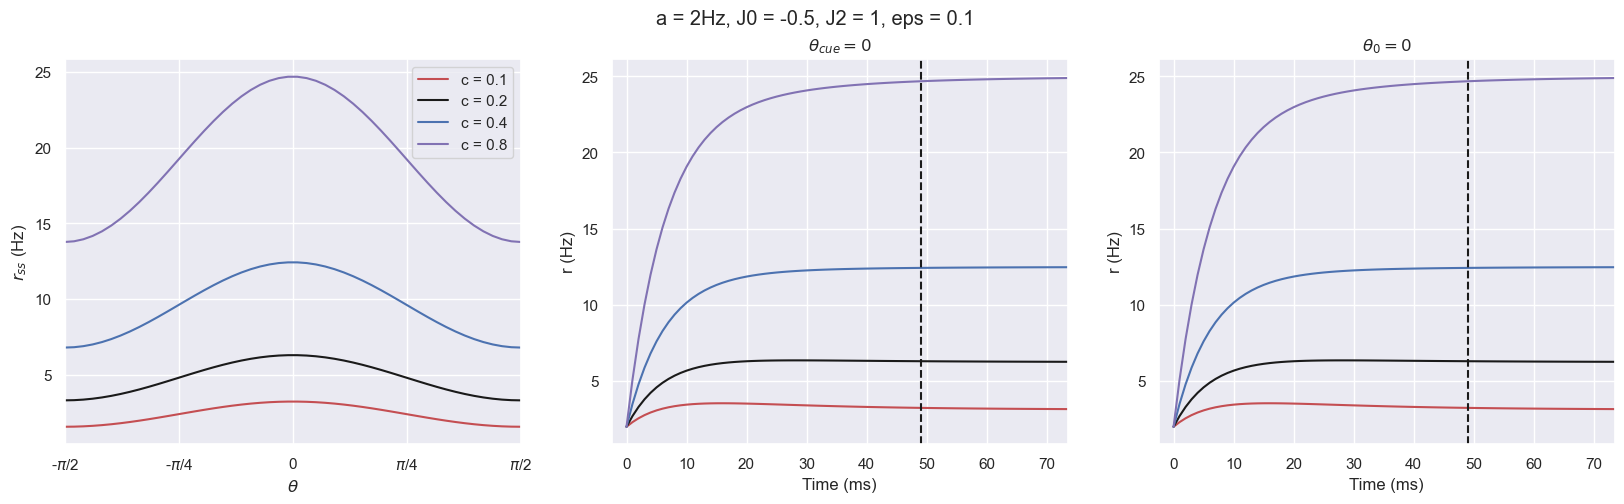

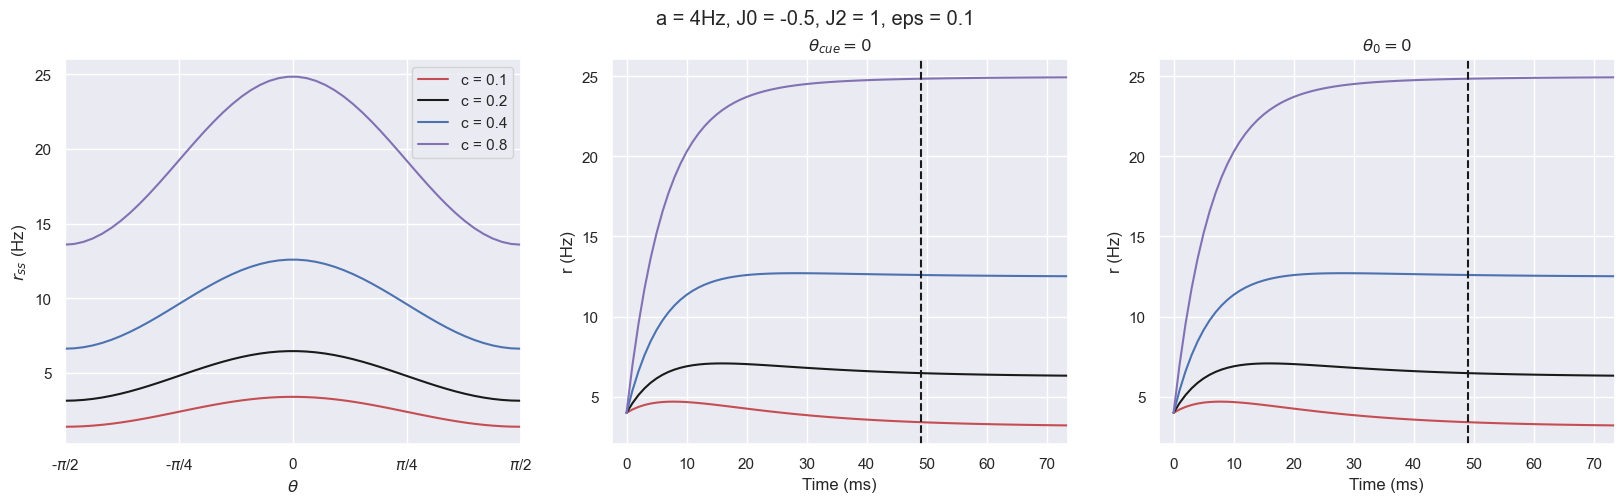

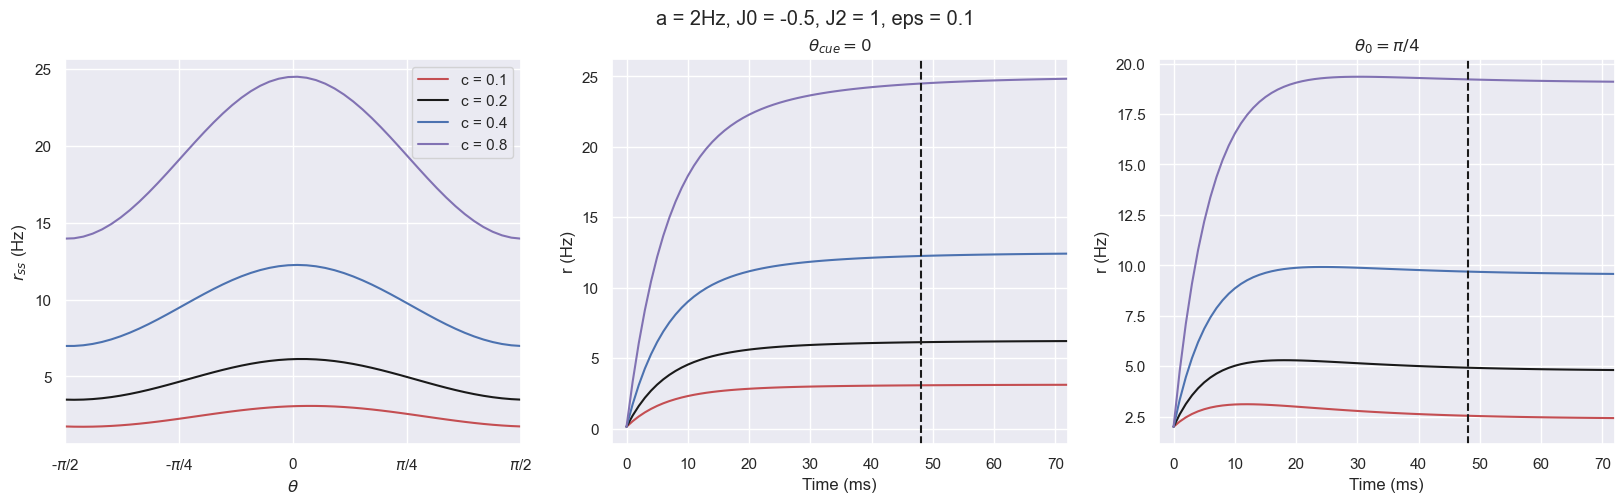

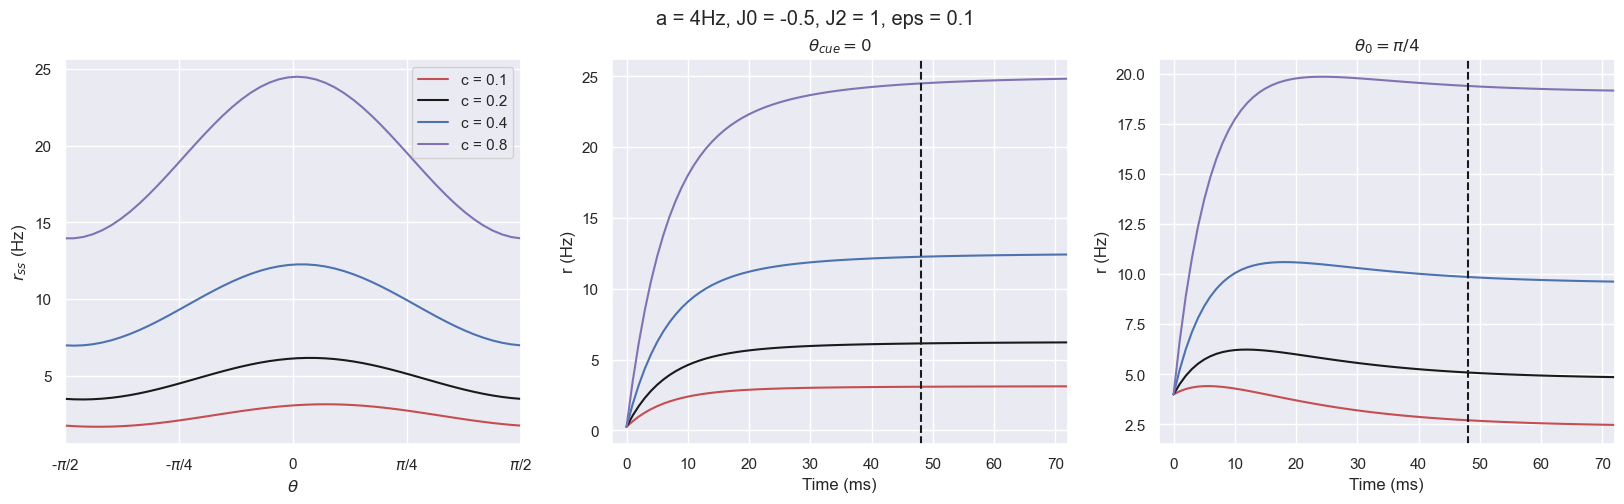

In [4]:
eps = 0.1
noisy = 0
noisiness = 3
J0 = -0.5
J2 = 1
second_term = recurrent_input(theta, J0, J2)
theta_0_s = [0, np.pi/4]
a_s = [2/1000, 4/1000] # cycles/ms
r_master =  np.zeros((len(contrasts), len(theta), len(T)))
steady_state_time = np.zeros(len(contrasts), dtype = int)
for theta_0 in theta_0_s:
    theta_0_idx = abs(theta - theta_0).argmin()
    for a in a_s:
        for cc in range(len(contrasts)):
            c = contrasts[cc]
            h_theta = h(A, c, eps, theta, theta_cue)
            steady_state_time[cc], r_master[cc] = firing_rate(theta, theta_0, T, tau, del_t, a, h_theta, second_term, noisy, noisiness)
        plot_steady_state(theta, contrasts, r_master, steady_state_time, theta_cue_idx, theta_0, theta_0_idx, a, J0, J2, eps, noisy, noisiness)

## Q2.
Here, we model the dynamics for the scenario where J0 = -7.3 J2 = 11, epsilon = 0.1 for a = 2 and 4 Hz. Like in Q1, we see that the steady-state firing rate is determined by the contrast and is higher for higher contrasts. However, unlike in Q1, here the steady-state is determined by $\theta_0$. When $\theta_0 = \theta_{cue}$, the steady-state is more stable and is reached faster. On the other hand, when $\theta_0 \neq \theta_{cue}$, the steady-state is less-stable, and is achieved much later. It is driven largely by $\theta_0$, however, it appears that the dynamics is initially driven heavily by $\theta_0 $, but then the peak starts drifting towards the baselind $\theta_{cue} $. We can also see that this drift is faster for higher contrasts and starts earlier for 2 Hz baseline state.

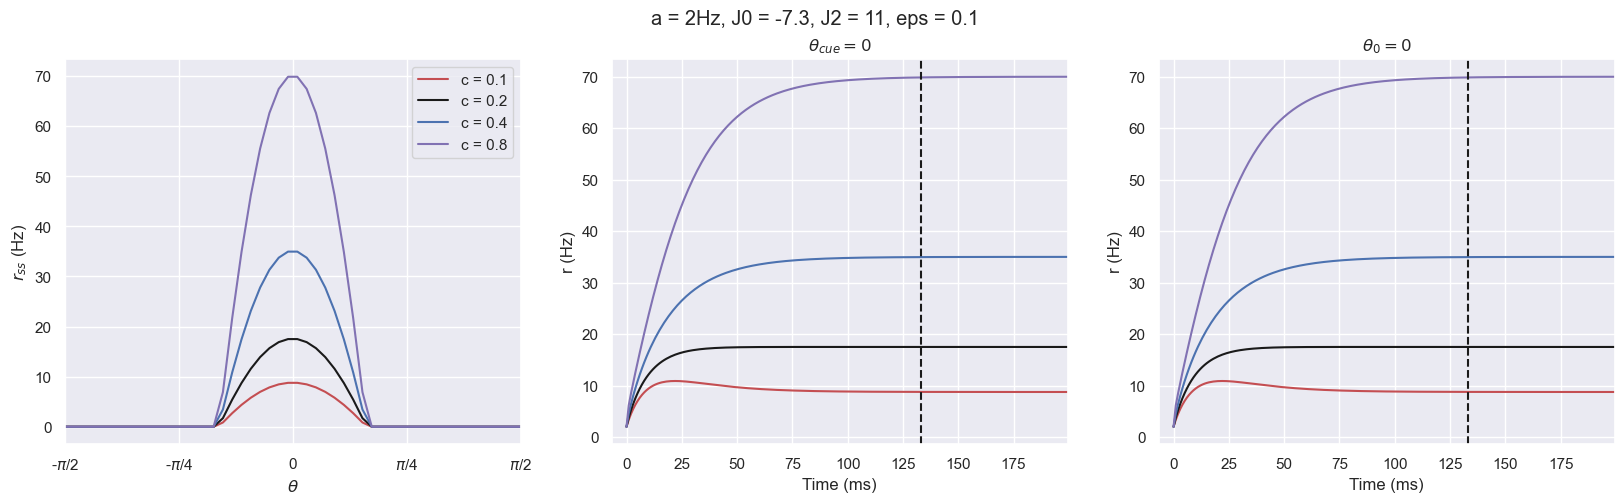

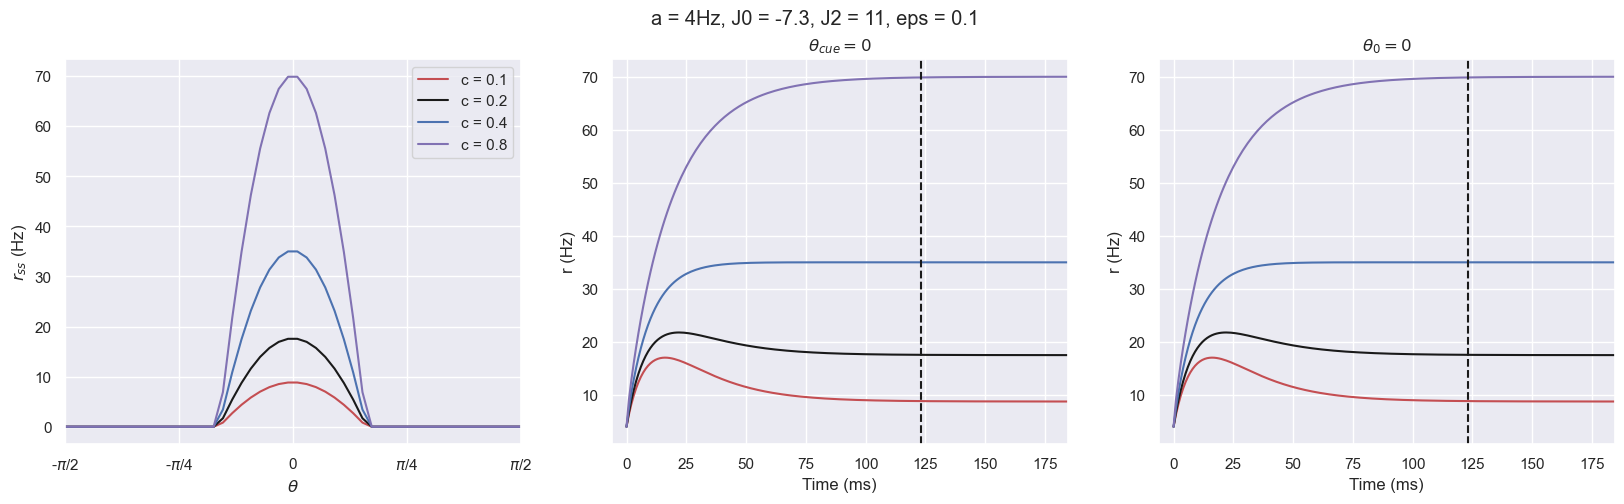

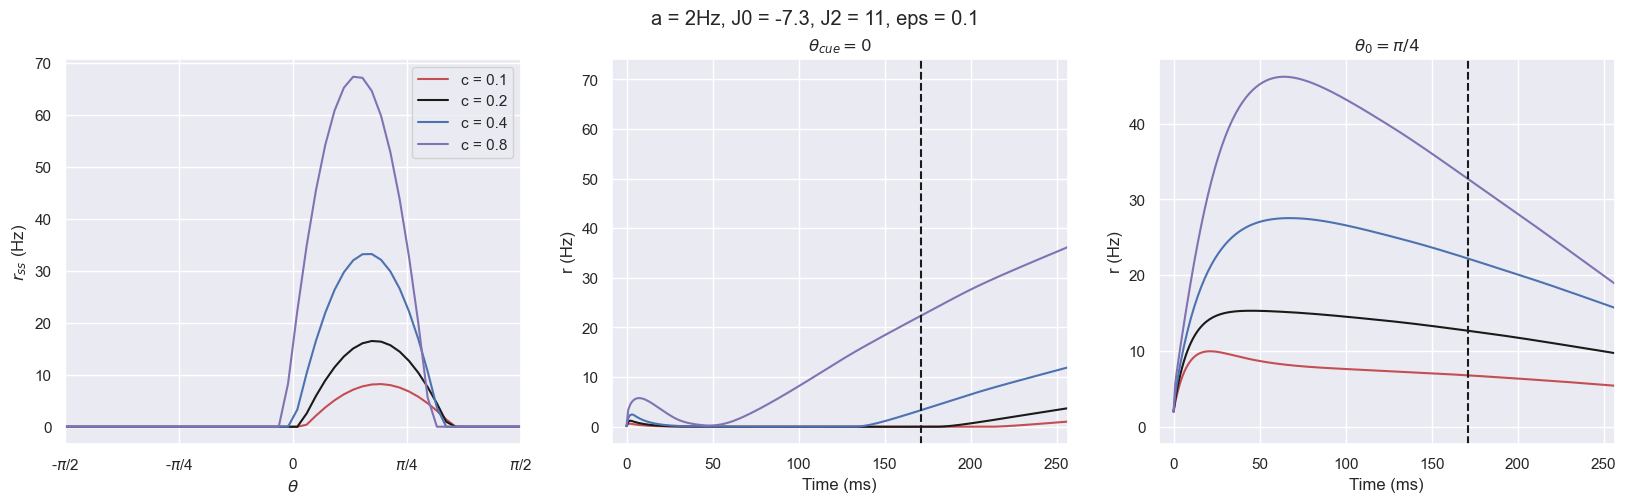

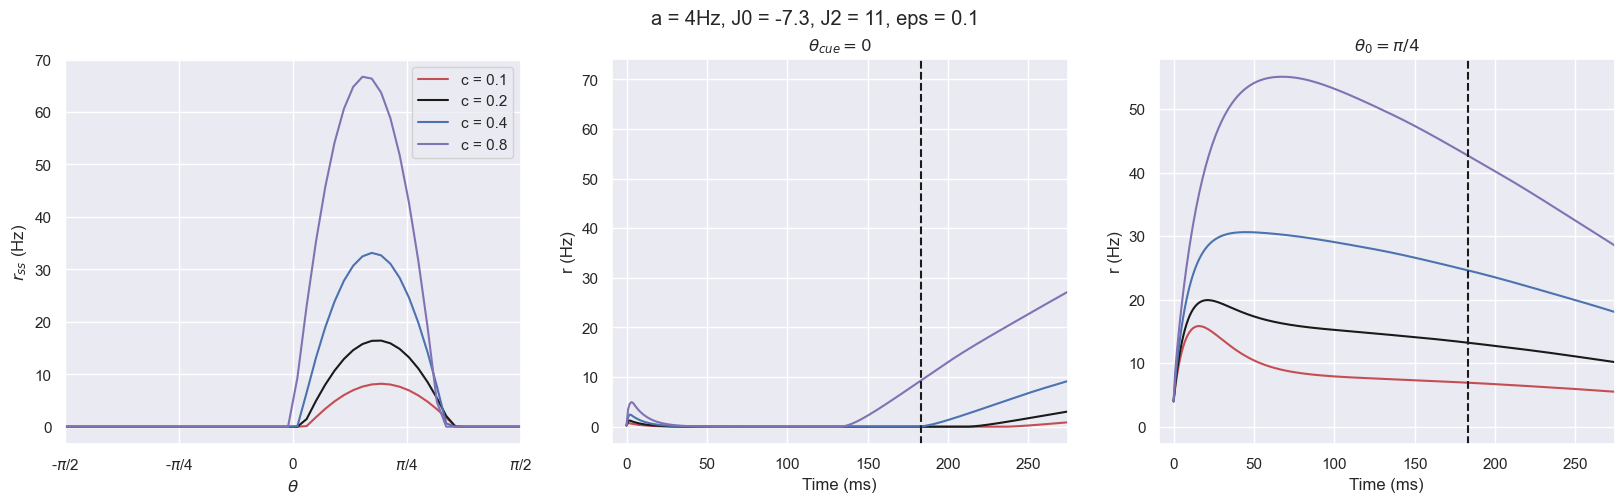

In [5]:
eps = 0.1
noisy = 0
noisiness = 3
J0 = -7.3
J2 = 11
second_term = recurrent_input(theta, J0, J2)
theta_0_s = [0, np.pi/4]
a_s = [2/1000, 4/1000] # cycles/ms
r_master =  np.zeros((len(contrasts), len(theta), len(T)))
steady_state_time = np.zeros(len(contrasts), dtype = int)
for theta_0 in theta_0_s:
    theta_0_idx = abs(theta - theta_0).argmin()
    for a in a_s:
        for cc in range(len(contrasts)):
            c = contrasts[cc]
            h_theta = h(A, c, eps, theta, theta_cue)
            steady_state_time[cc], r_master[cc] = firing_rate(theta, theta_0, T, tau, del_t, a, h_theta, second_term, noisy, noisiness)
        plot_steady_state(theta, contrasts, r_master, steady_state_time, theta_cue_idx, theta_0, theta_0_idx, a, J0, J2, eps, noisy, noisiness)

## Q3.
The dynamics of 1 are implemented with the change that there is a gaussian noise added to the thalamic input. The standard deviation of the noise is varied to see its effect. Like Q1, we can see that higher contrasts have a higher steady-state than lower contrasts. Also, the steady-state dyanmics is driven by the baseline tuning of the population. As the noisiness of the thalamic input increases, it induces more uniform activation across the population at steady-state. Here the dynamics are shown for 2Hz condition. However, similar results for 4Hz.

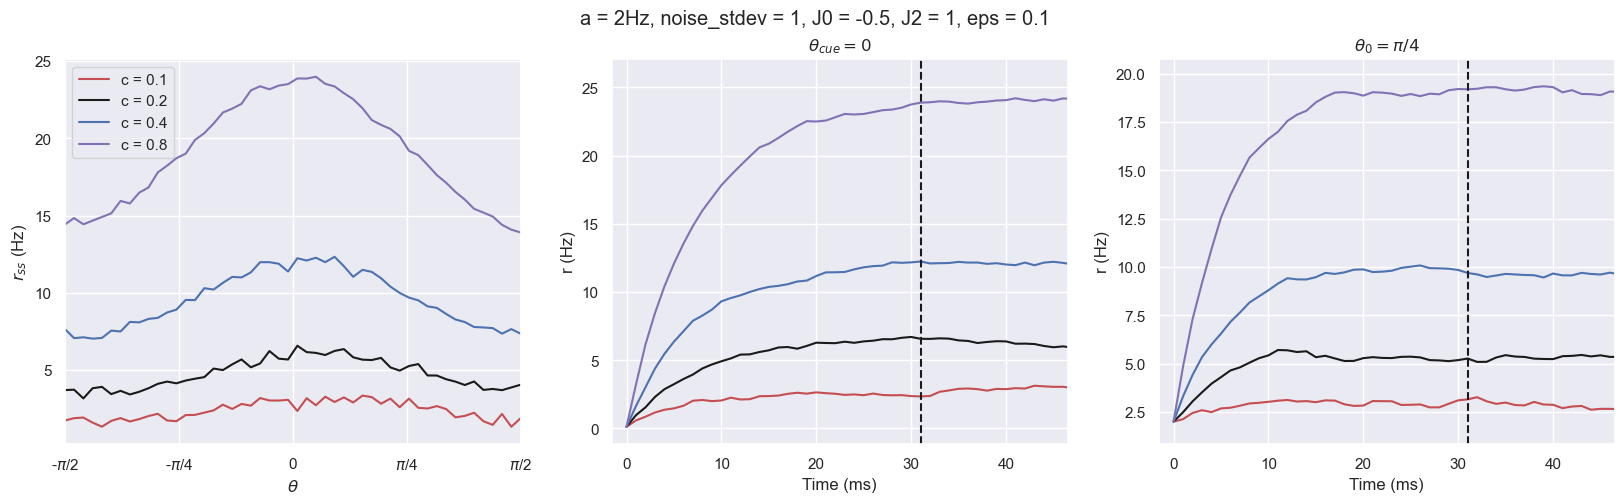

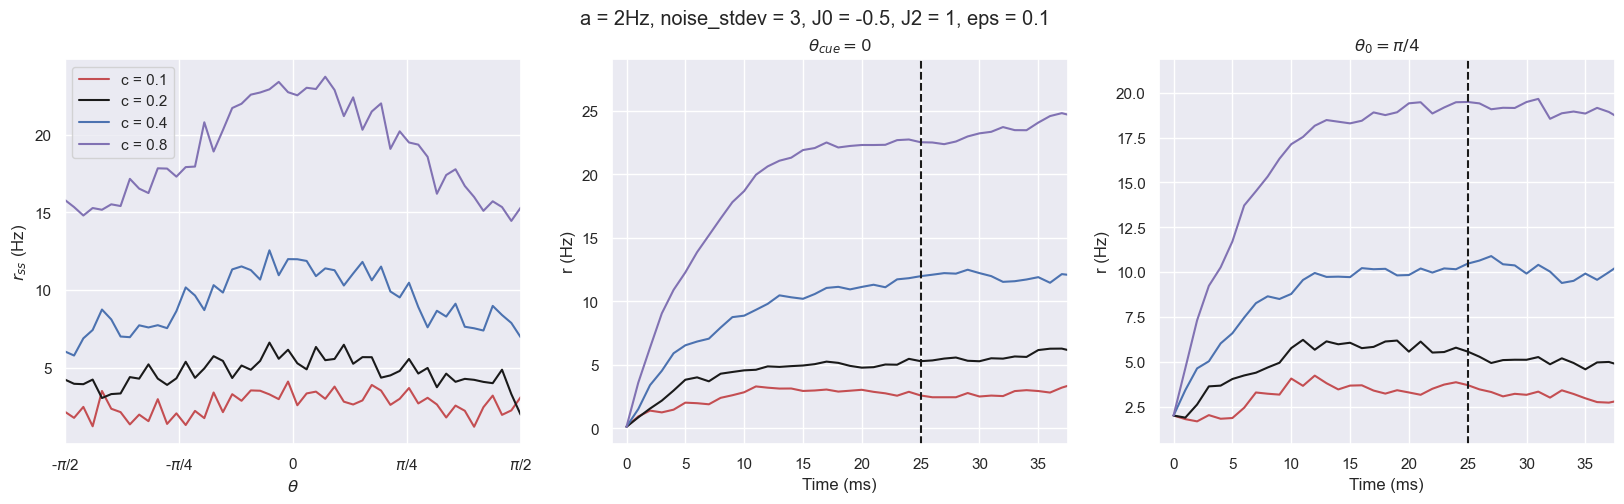

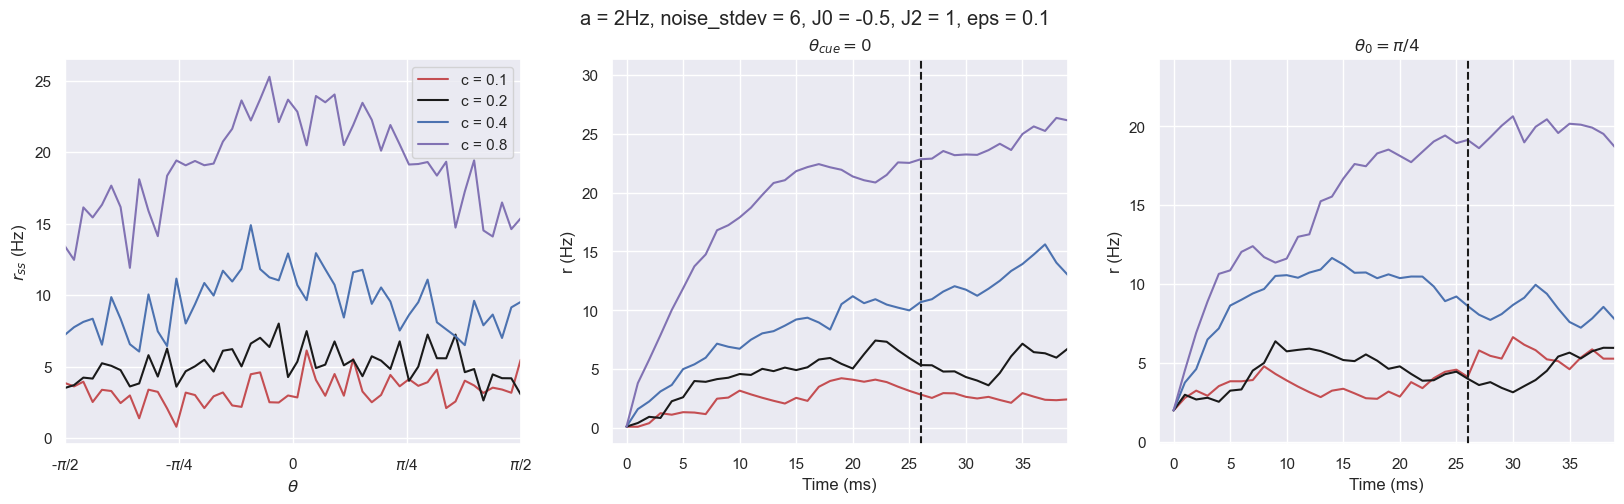

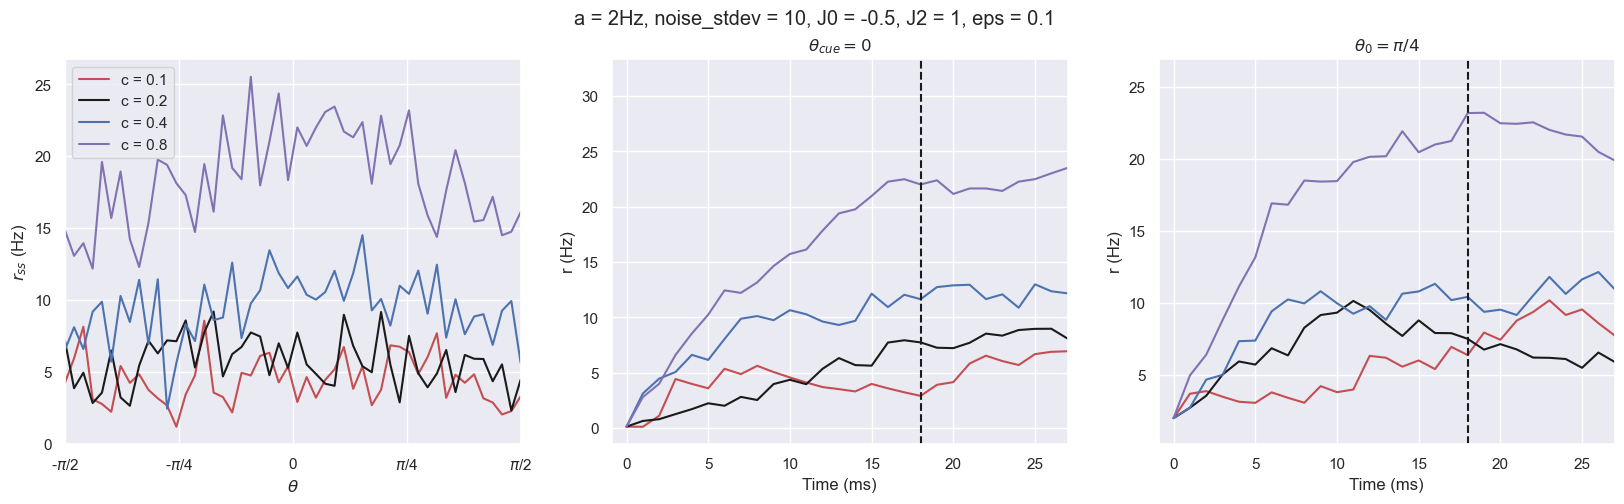

In [6]:
eps = 0.1
noisy = 1
noisiness_array = [1, 3, 6, 10]
J0 = -0.5
J2 = 1
second_term = recurrent_input(theta, J0, J2)
theta_0 = np.pi/4
theta_0_idx = abs(theta - theta_0).argmin()
a = 2/1000 # cycles/ms
r_master =  np.zeros((len(contrasts), len(theta), len(T)))
steady_state_time = np.zeros(len(contrasts), dtype = int)
for noisiness in noisiness_array:
    for cc in range(len(contrasts)):
        c = contrasts[cc]
        h_theta = h(A, c, eps, theta, theta_cue)
        steady_state_time[cc], r_master[cc] = firing_rate(theta, theta_0, T, tau, del_t, a, h_theta, second_term, noisy, noisiness)
    plot_steady_state(theta, contrasts, r_master, steady_state_time, theta_cue_idx, theta_0, theta_0_idx, a, J0, J2, eps, noisy, noisiness)

The dynamics of 2 are implemented with the change that there is a gaussian noise added to the thalamic input. The standard deviation of the noise is varied to see its effect. Like Q2, we can see that higher contrasts have a higher steady-state than lower contrasts. Also, the steady-state dyanmics is driven largely by the thalamic input. Unlike Q2, we can see that the noise affects the steady-state substantially. Specifically, noise appears to delay the tuning of the population by thalamic input, delay the decay of this tuning and also suppress the effect of recurrent connection. We can see that as the noise standard deviation increases, it takes longer for neurons corresponding to $\theta_{cue} $ to start activating. Here the dynamics are shown for 2Hz condition. However, similar results for 4Hz.

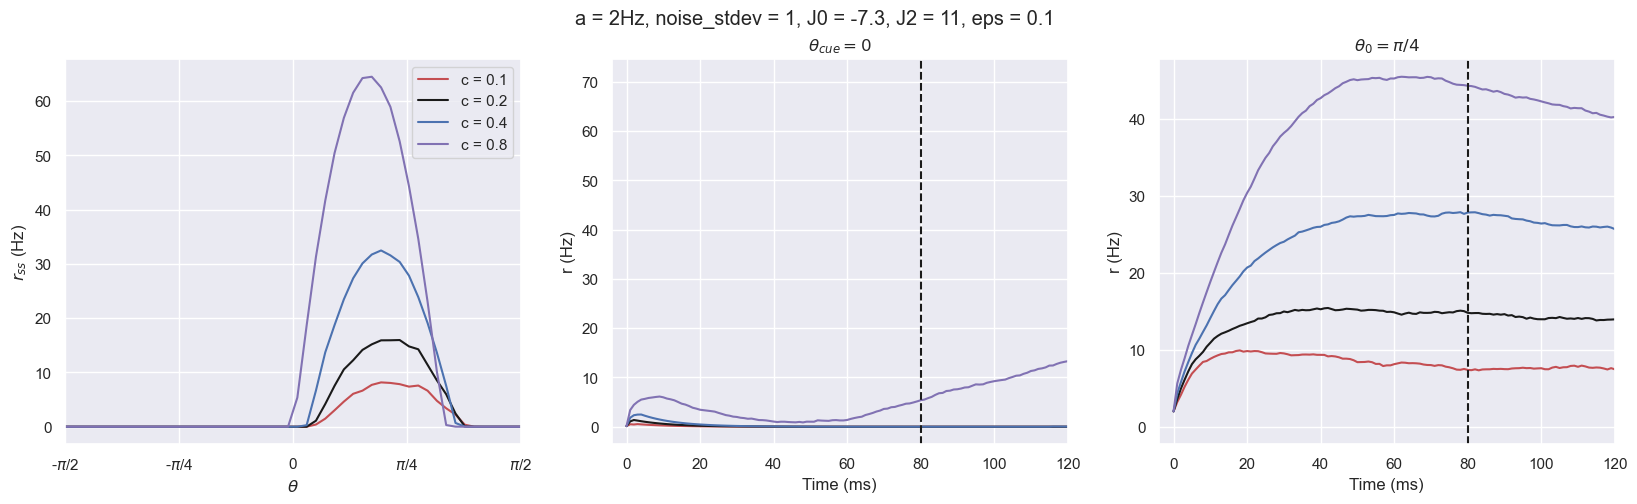

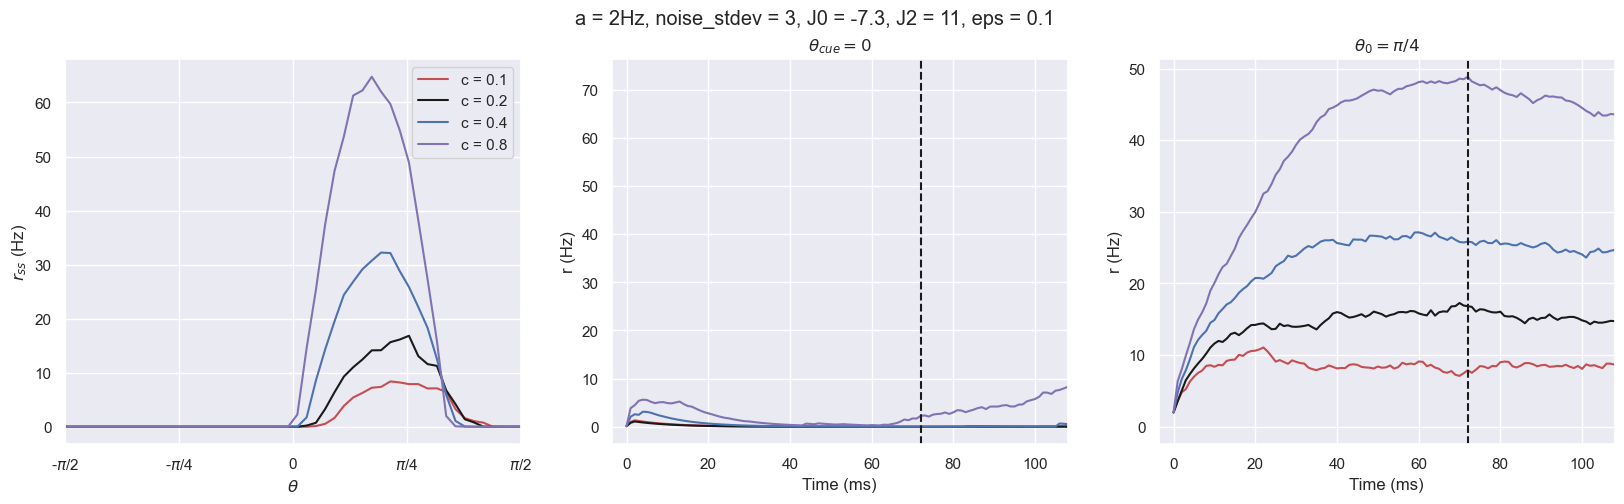

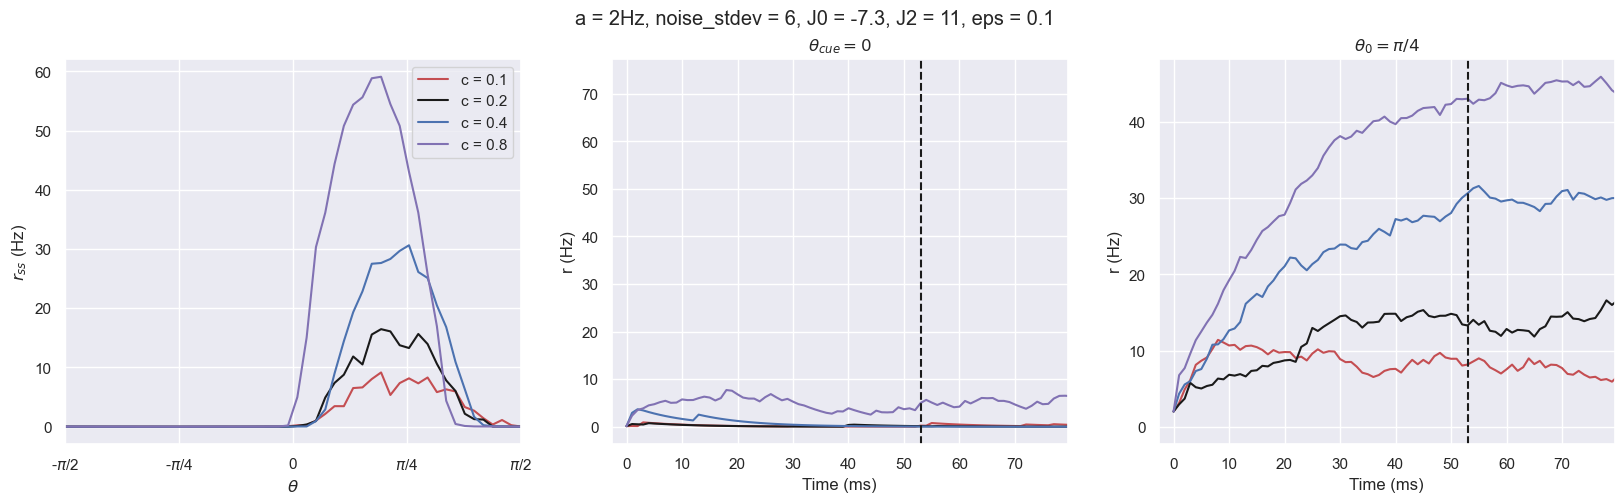

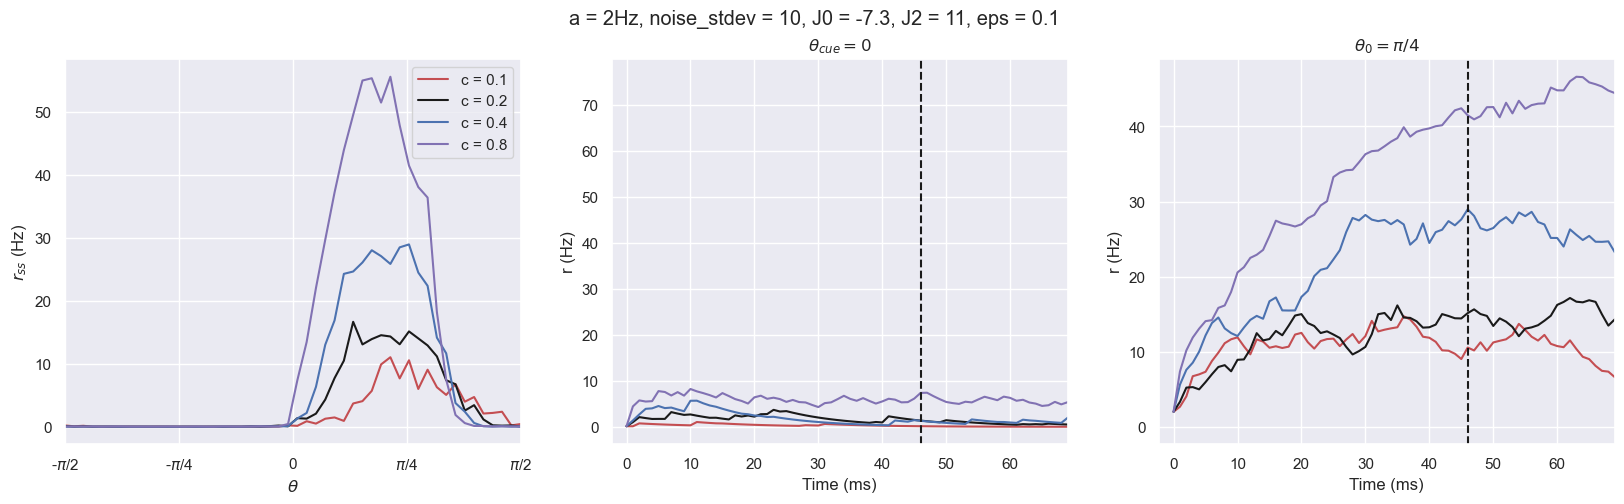

In [7]:
eps = 0.1
noisy = 1
noisiness_array = [1, 3, 6, 10]
J0 = -7.3
J2 = 11
second_term = recurrent_input(theta, J0, J2)
theta_0 = np.pi/4
theta_0_idx = abs(theta - theta_0).argmin()
a = 2/1000 # cycles/ms
r_master =  np.zeros((len(contrasts), len(theta), len(T)))
steady_state_time = np.zeros(len(contrasts), dtype = int)
for noisiness in noisiness_array:
    for cc in range(len(contrasts)):
        c = contrasts[cc]
        h_theta = h(A, c, eps, theta, theta_cue)
        steady_state_time[cc], r_master[cc] = firing_rate(theta, theta_0, T, tau, del_t, a, h_theta, second_term, noisy, noisiness)
    plot_steady_state(theta, contrasts, r_master, steady_state_time, theta_cue_idx, theta_0, theta_0_idx, a, J0, J2, eps, noisy, noisiness)

## Q4.
Largely, the dynamics are driven by the parameters J0 and J2. We can classify the dyanmics into 3 types: Homogeneous where at steady-state the activity spreads over the population or remains tuned to the initial baseline tuning of the population, Marginal where at steady-state dyanmics is tuned to the external input, and Amplitude Instability where the population never reaches steady-state and amplitude of the activation keeps shooting up. \
Here I have tried a range of parameters for $J_0$ and $J_2$ for $\epsilon = 0 $. \
For $J_0 = -1 $, we observe homogeneous steady-state for $J_2 = 0, 1, 2 $, marginal steady-state for $J_2 = 3, 4, 5$, and it attains amplitude instability for $J_2 = 6 $ \
For $J_0 = 0 $, we observe homogeneous steady-state for $J_2 = 0, 1 $, marginal steady-state for $J_2 = 2, 3$, and it attains amplitude instability for $J_2 = 4, 5, 6 $ \
For $J_0 = 1 $, we observe a steady-state in between homogeneous and amplitude instability for $J_2 = 0, 1 $ (the activation is uniform across population but explodes over time), and it attains amplitude instability for $J_2 = 2, 3, 4, 5, 6 $, however, this amplitude instability maintains the preference of the thalamic input thereby resembling an exploding marginal steady-state. \
For $J_0 = 2 $, we observe an amplitude instability for all values of $J_2 $. However, there is a qualitative difference in the amplitude instability for $J_2 = 0, 1, 2, 3 $ where the exploding amplitude happens uniformly over the popluation, whereas for $J_2 = 4, 5, 6$, it resembles an exploding marginal steady-state. \
This matches the state diagram (Figure 3.19)

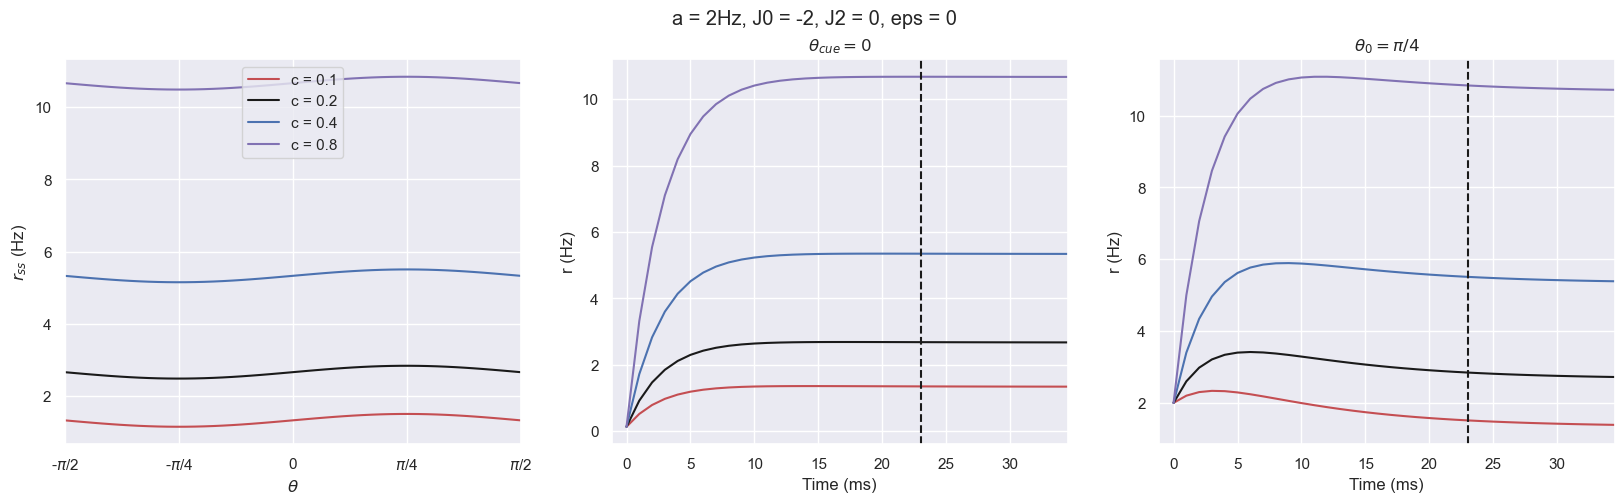

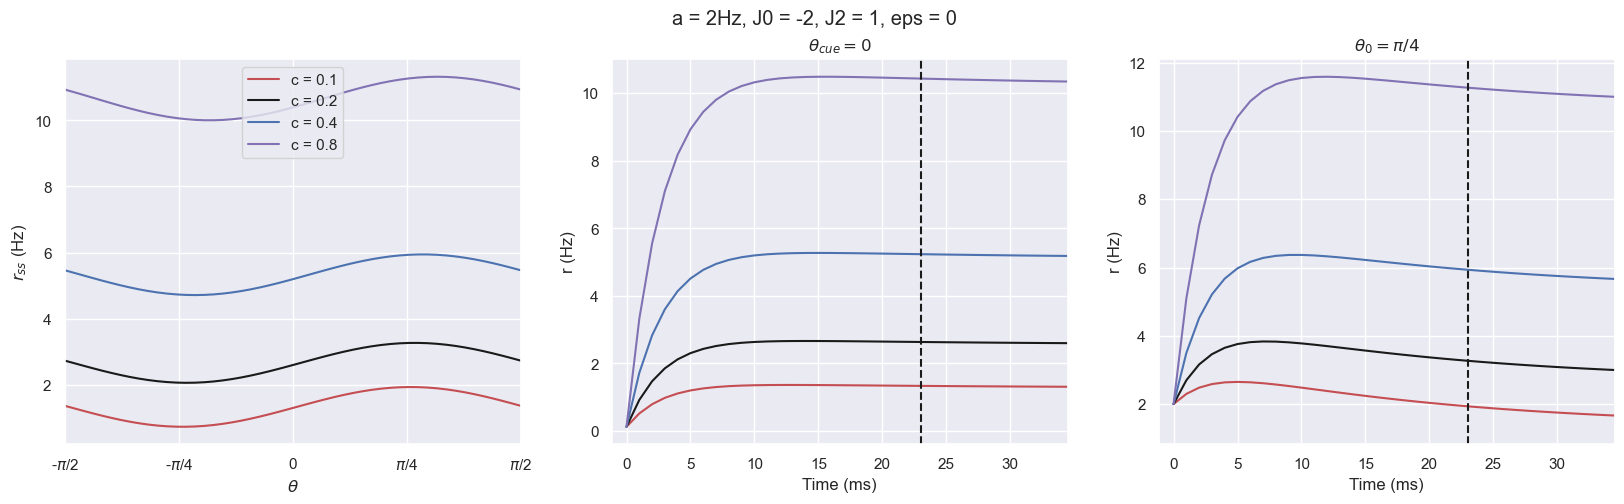

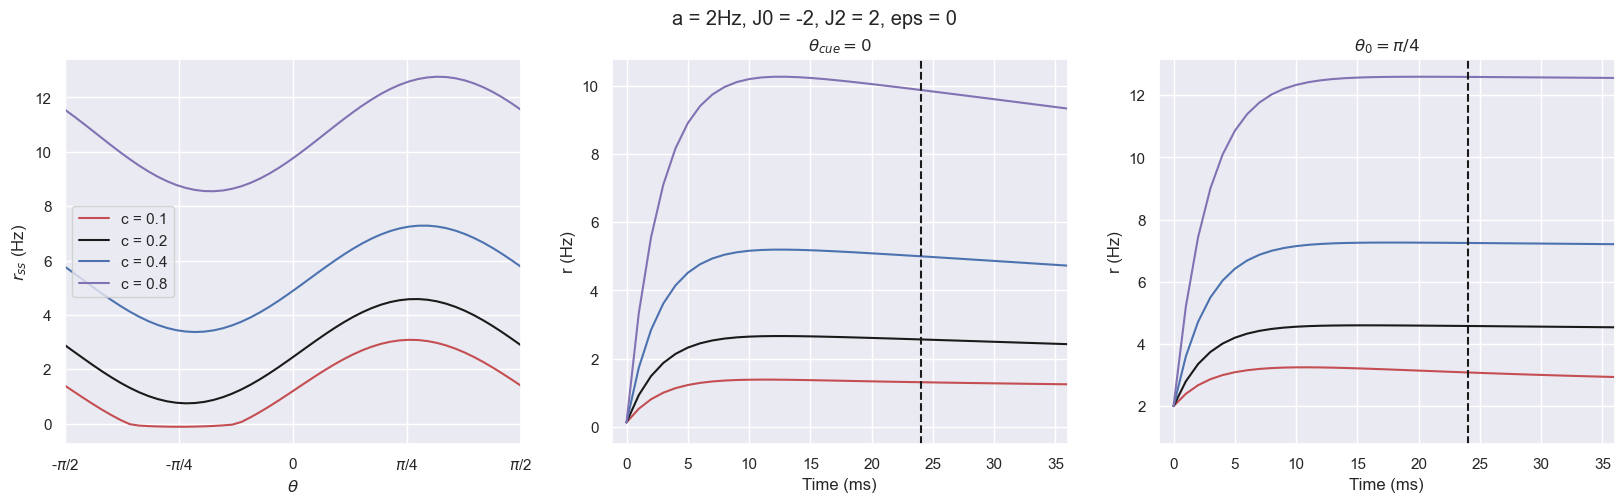

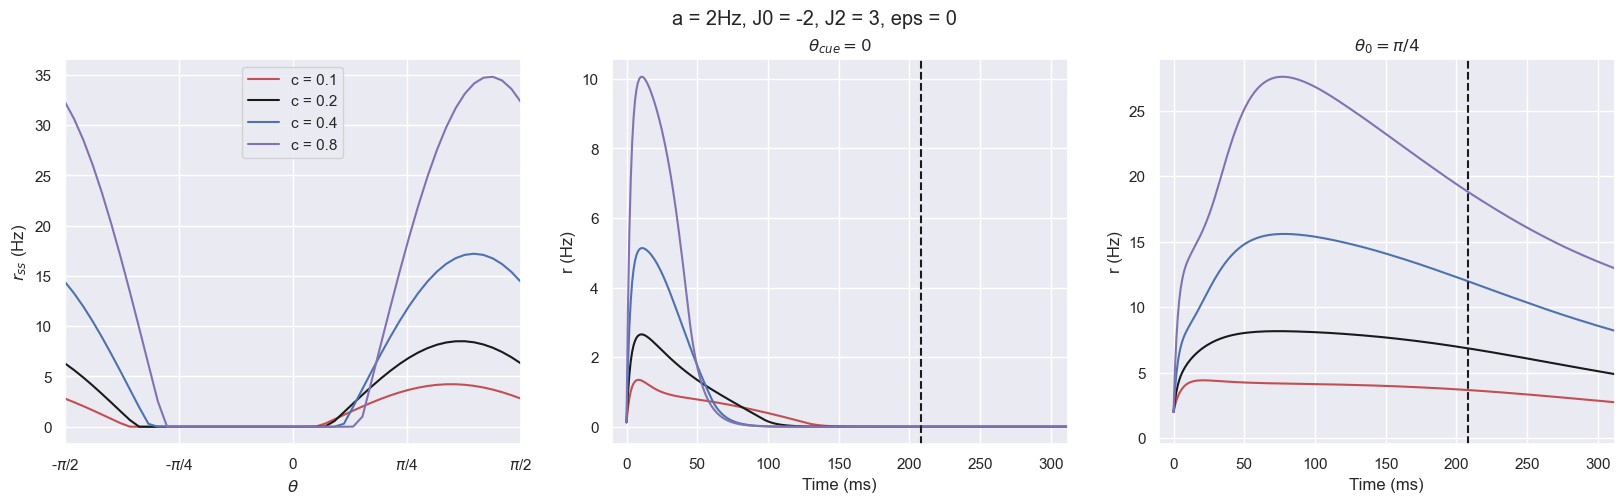

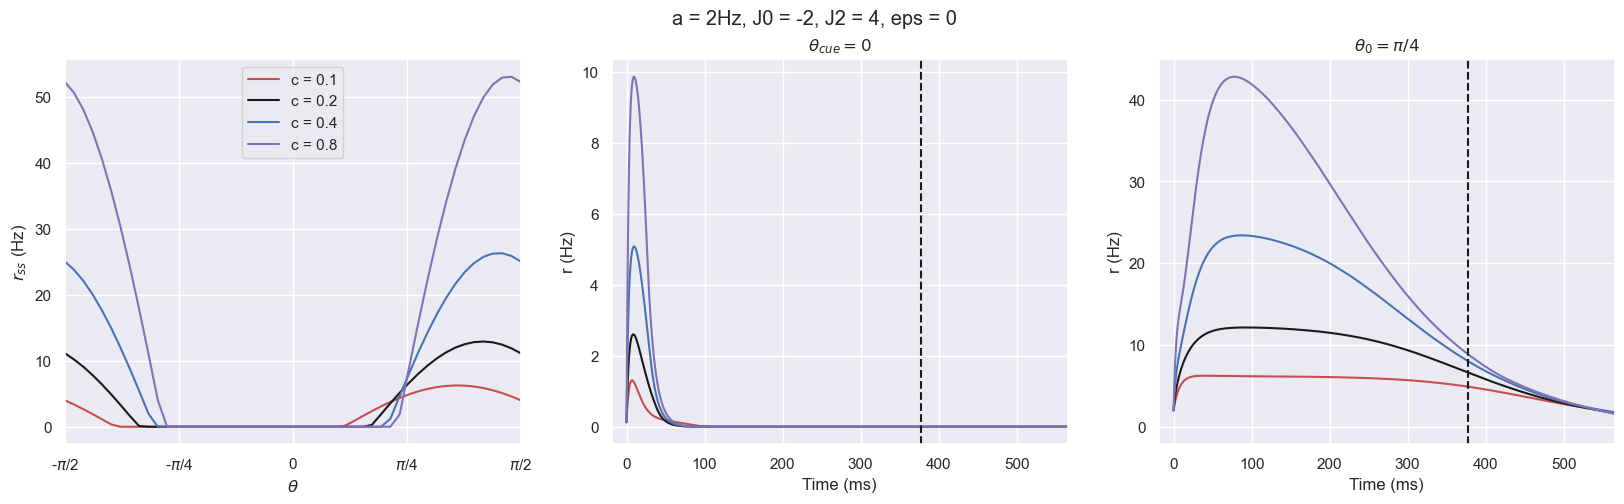

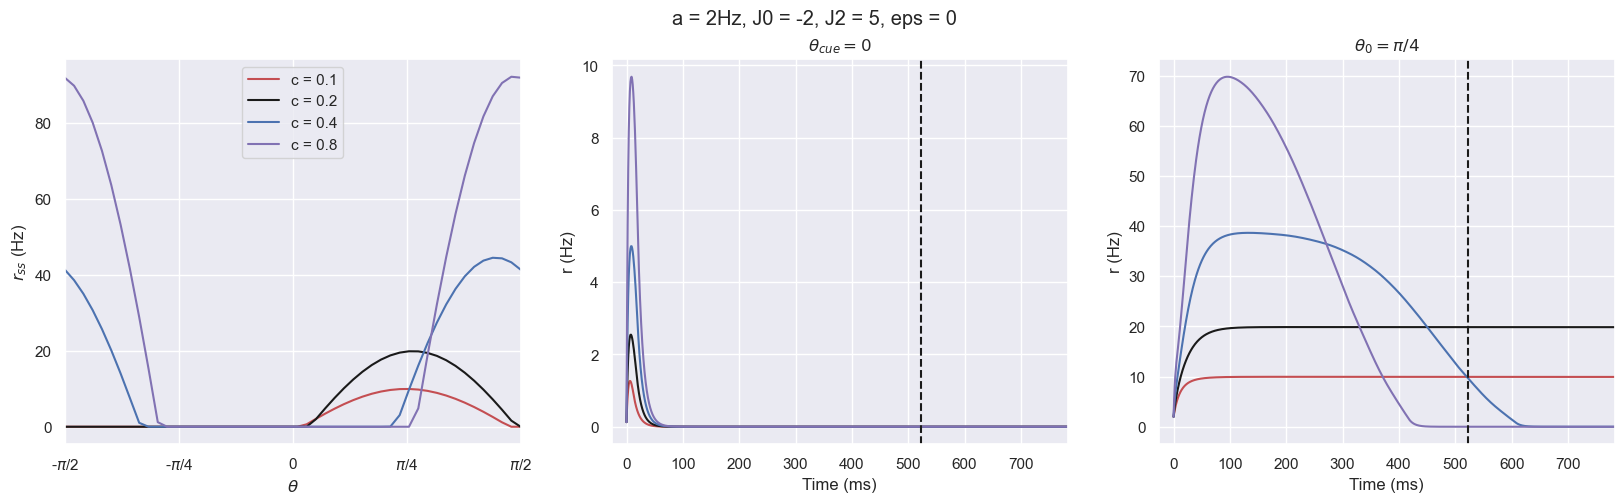

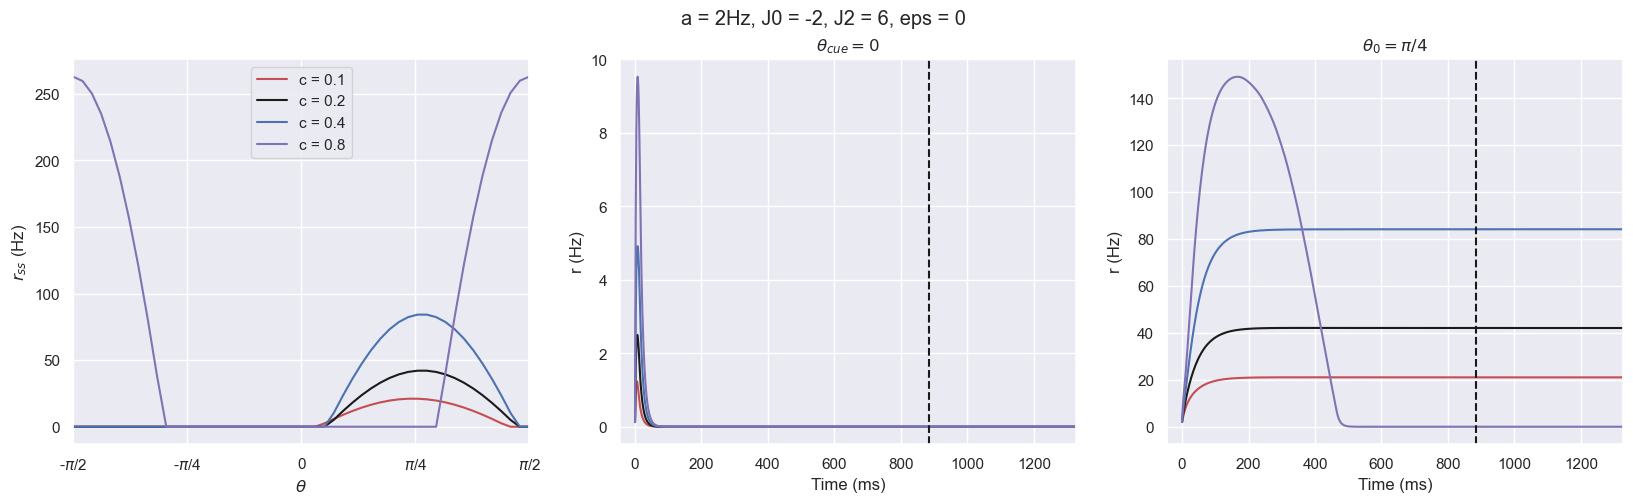

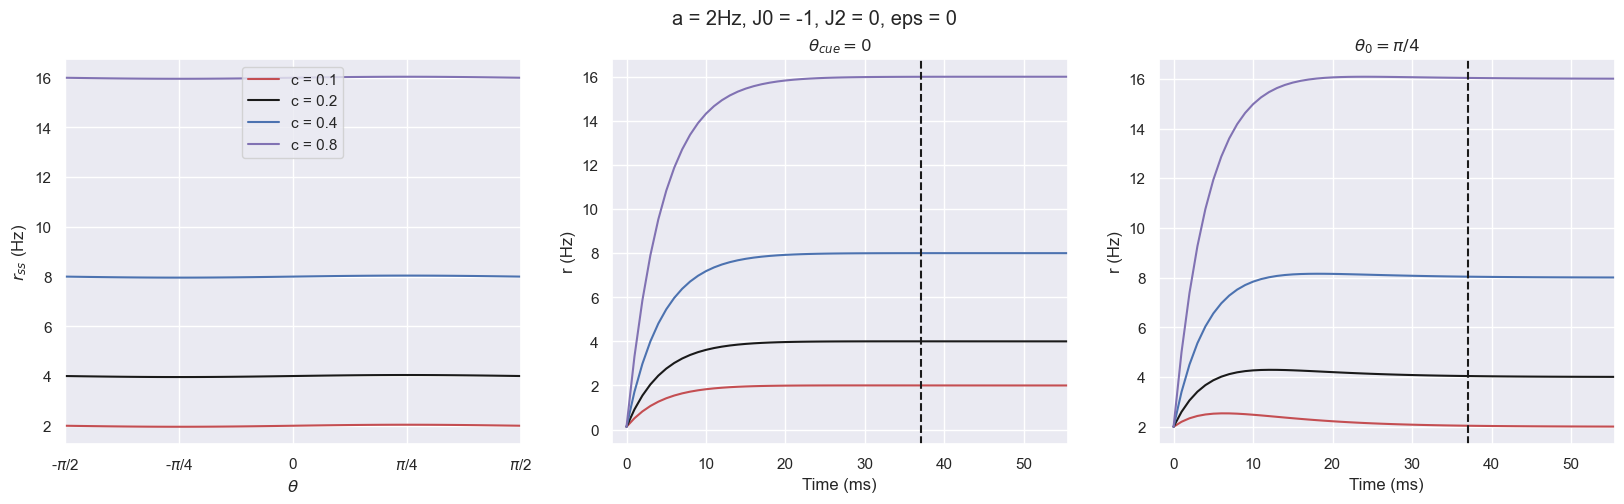

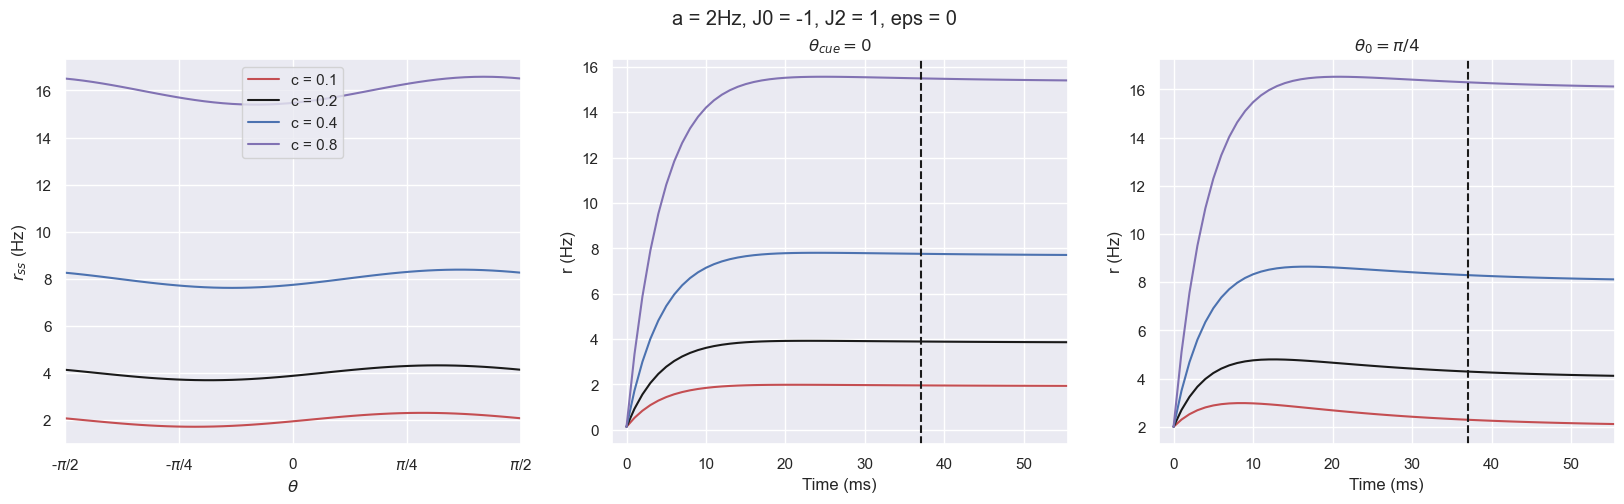

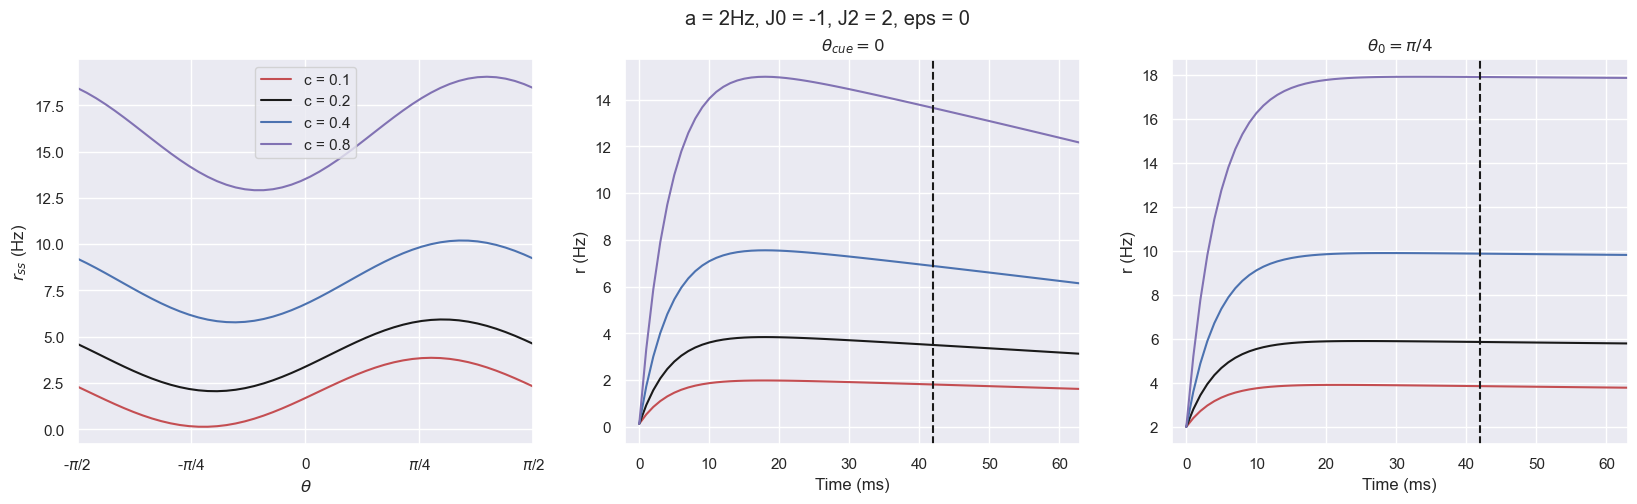

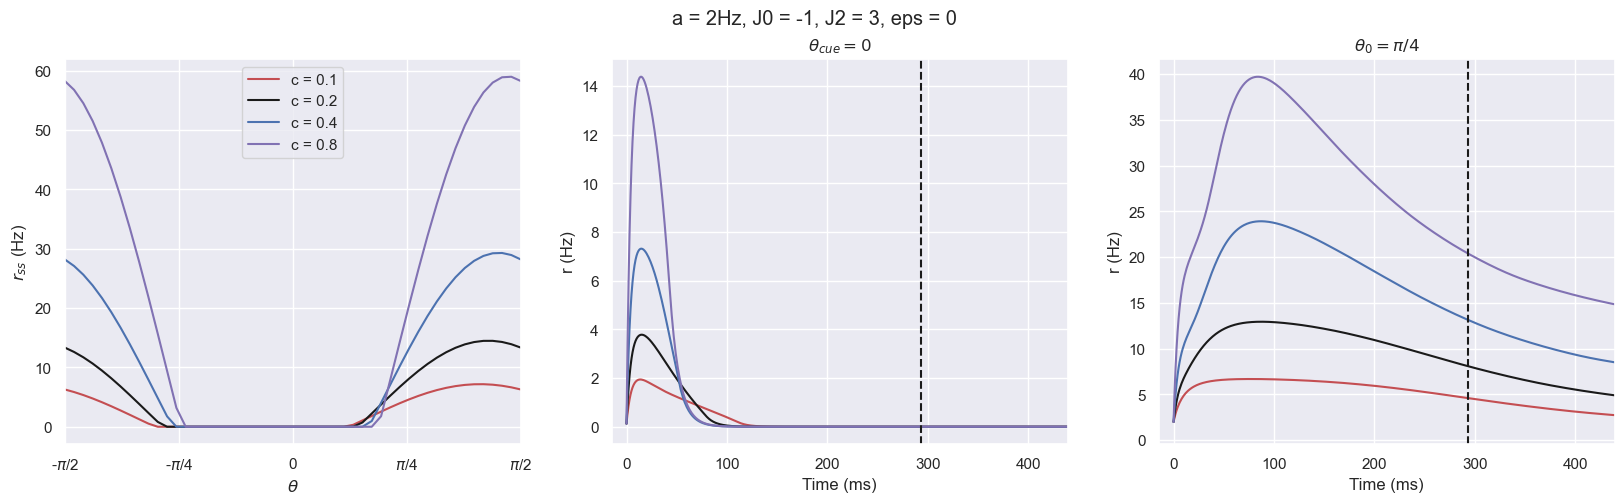

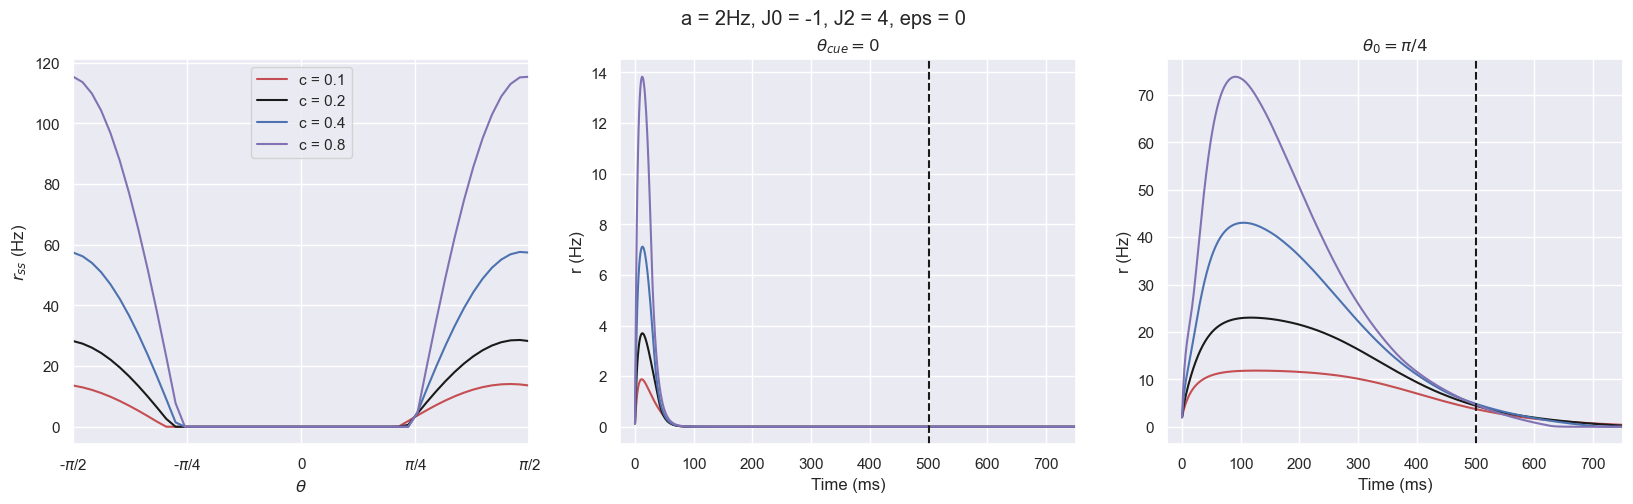

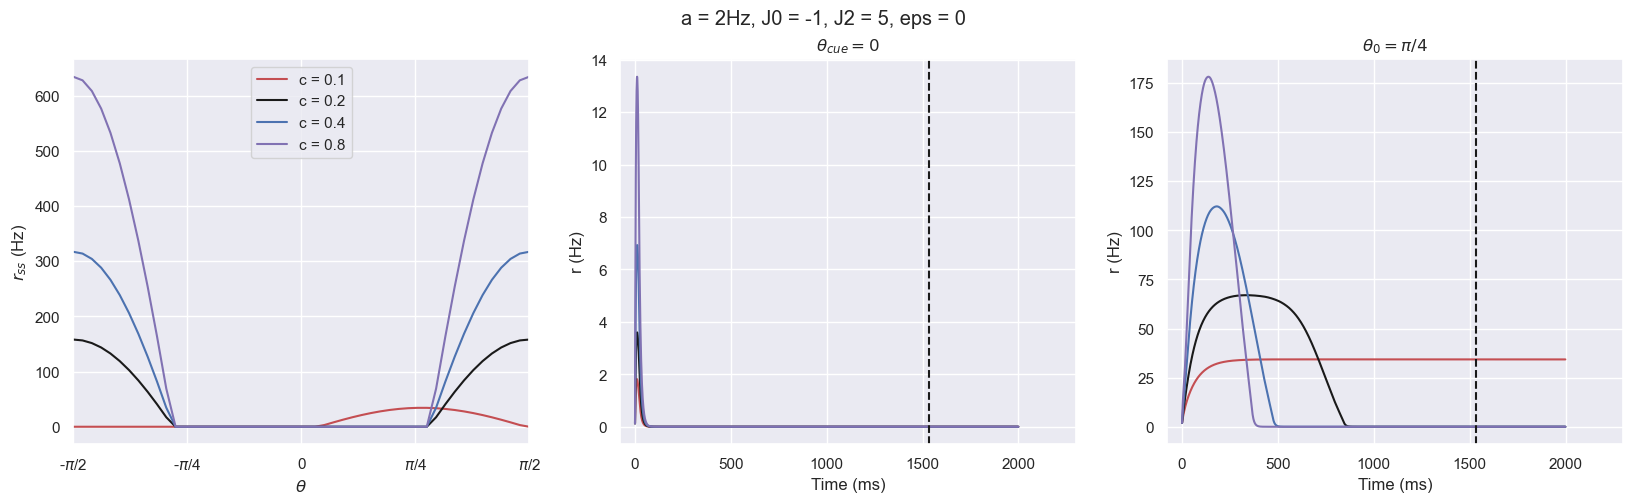

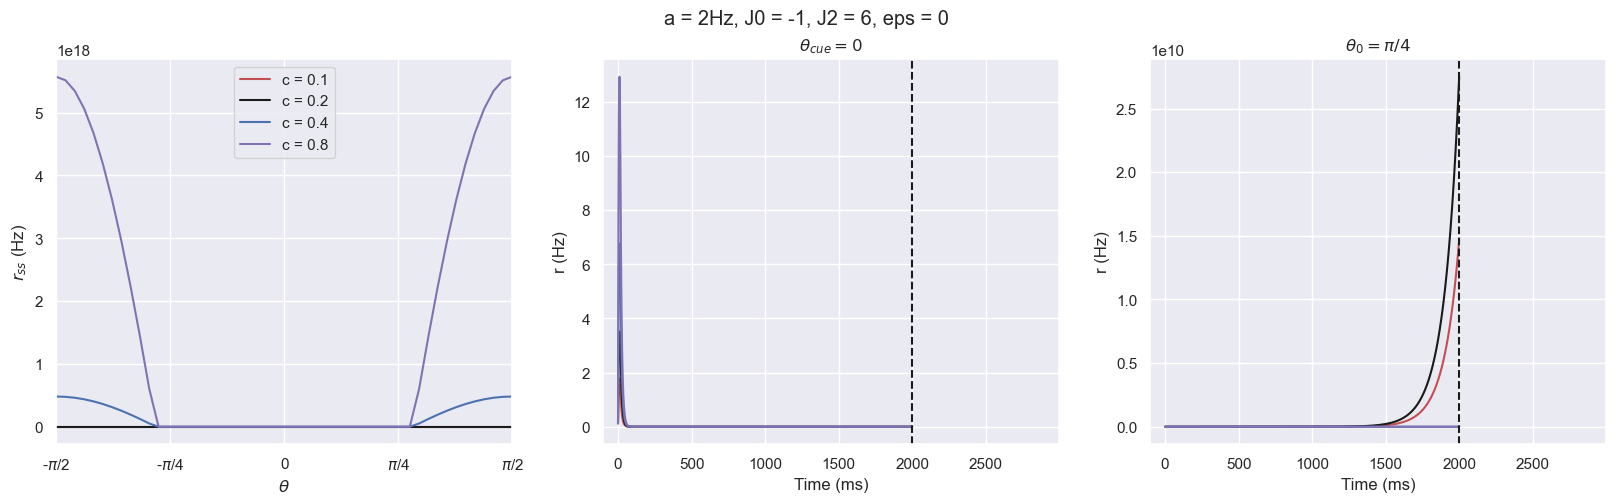

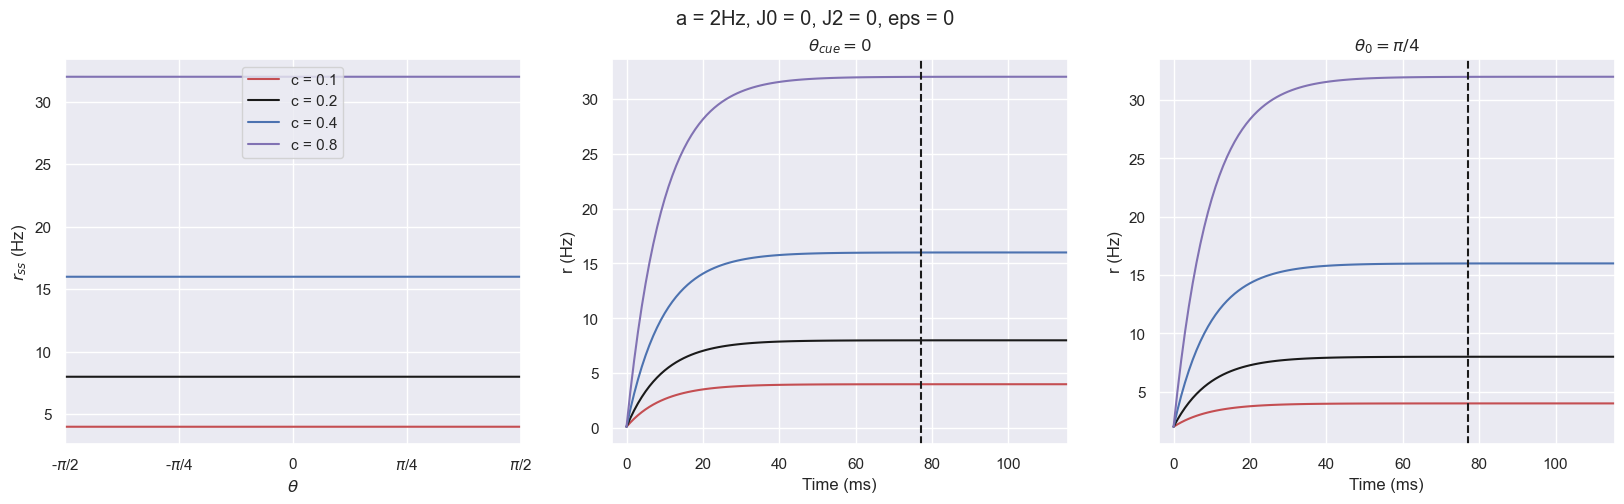

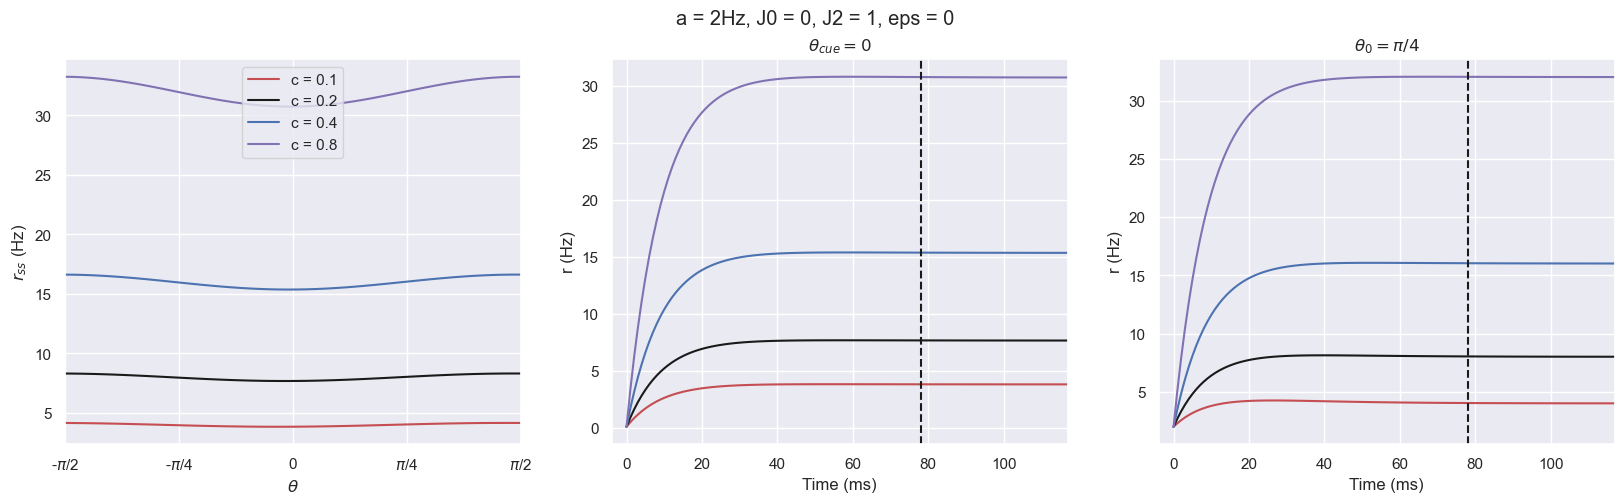

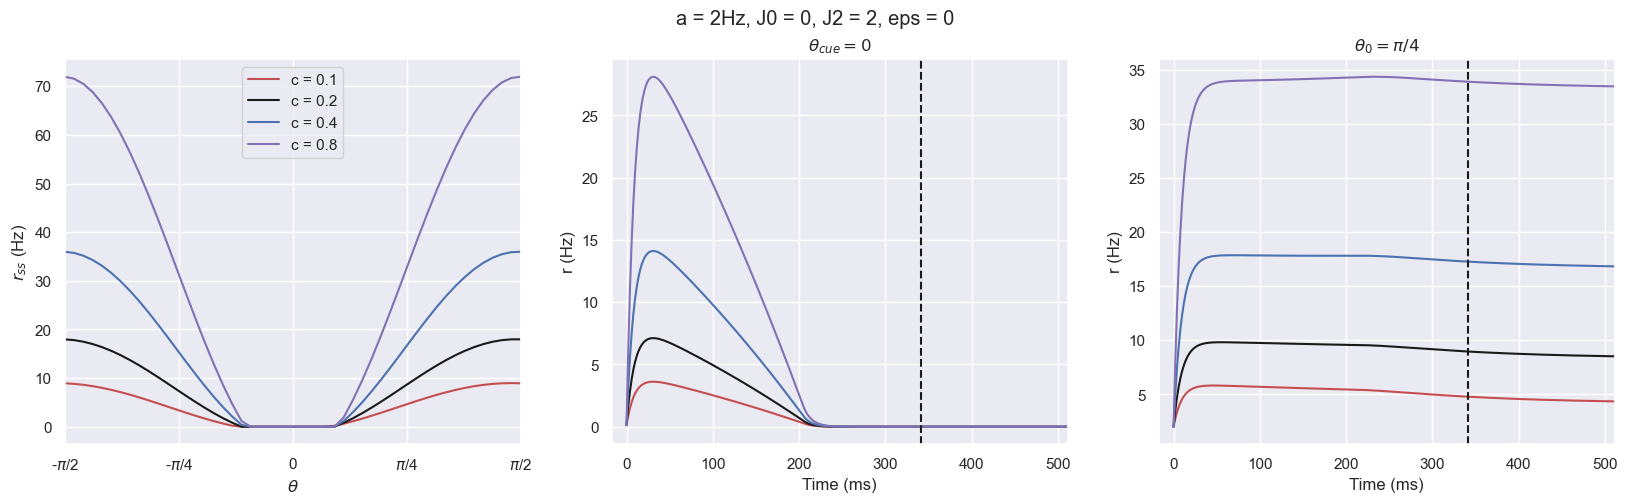

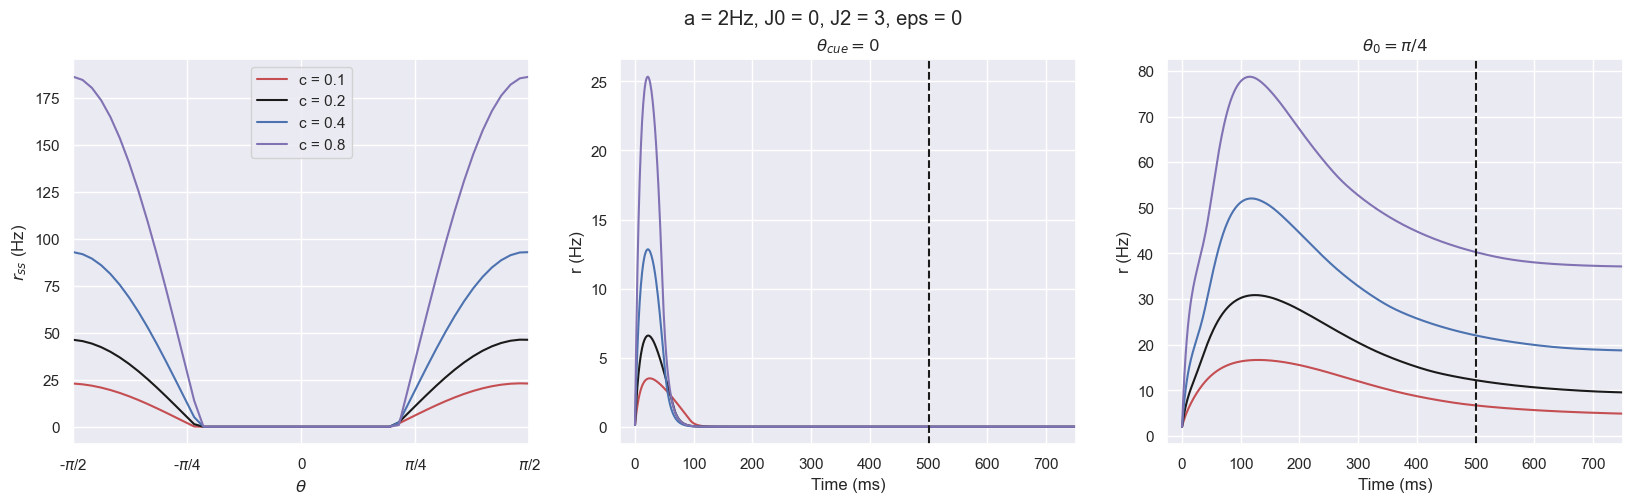

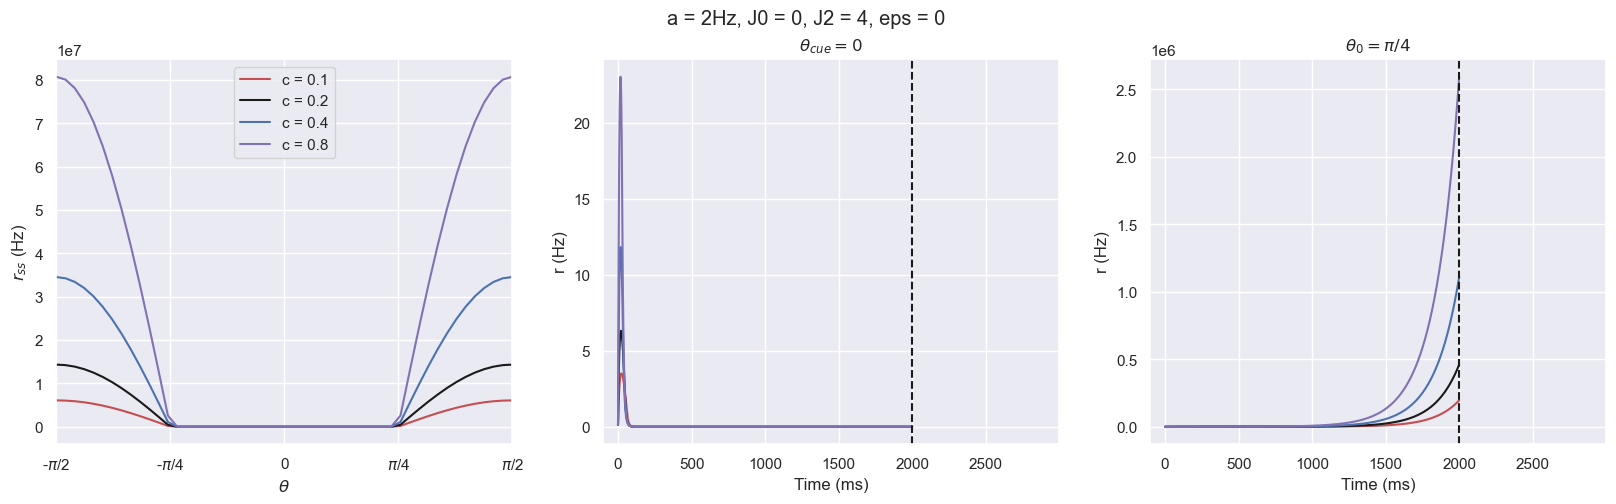

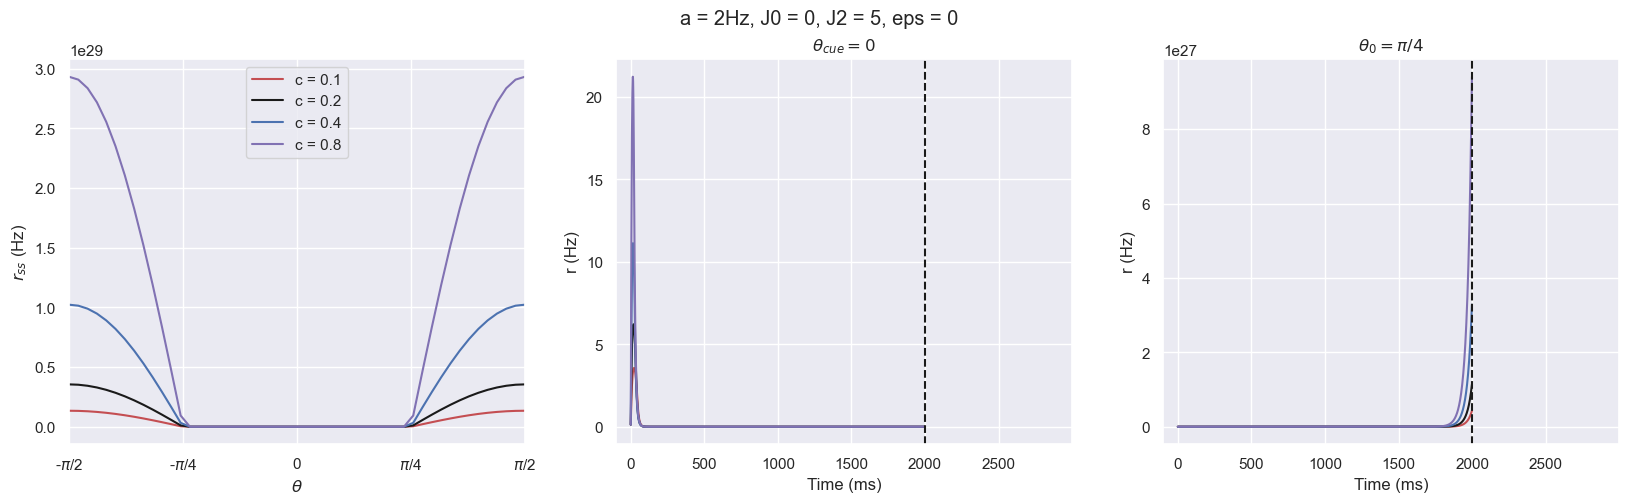

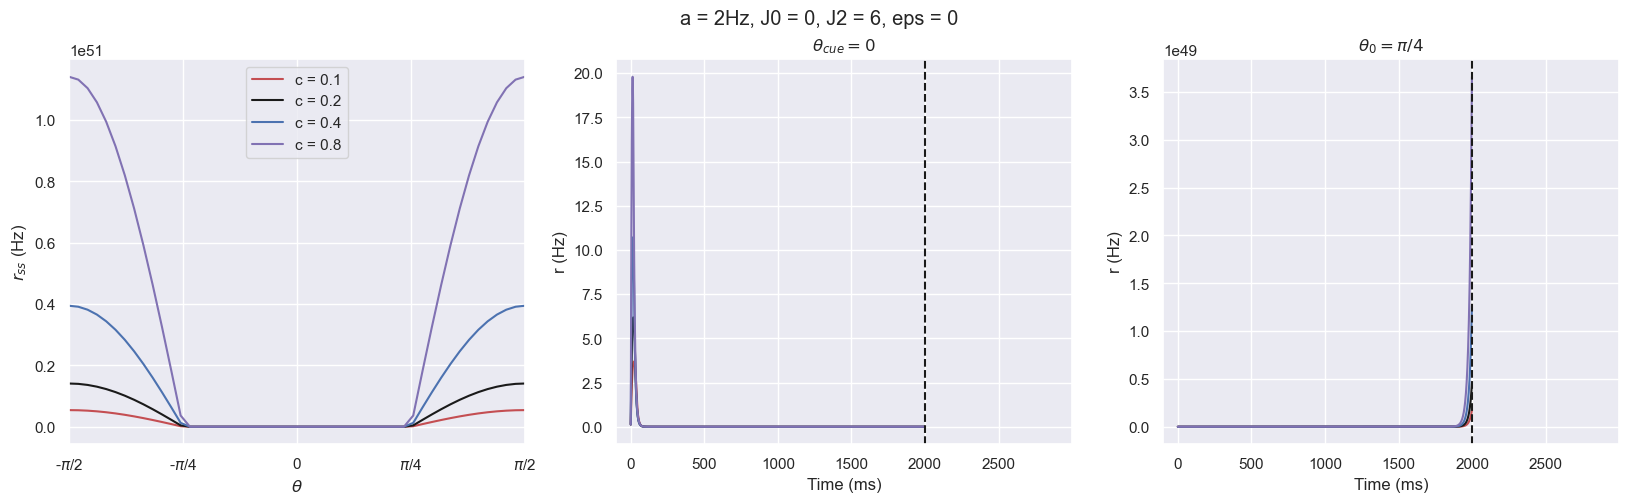

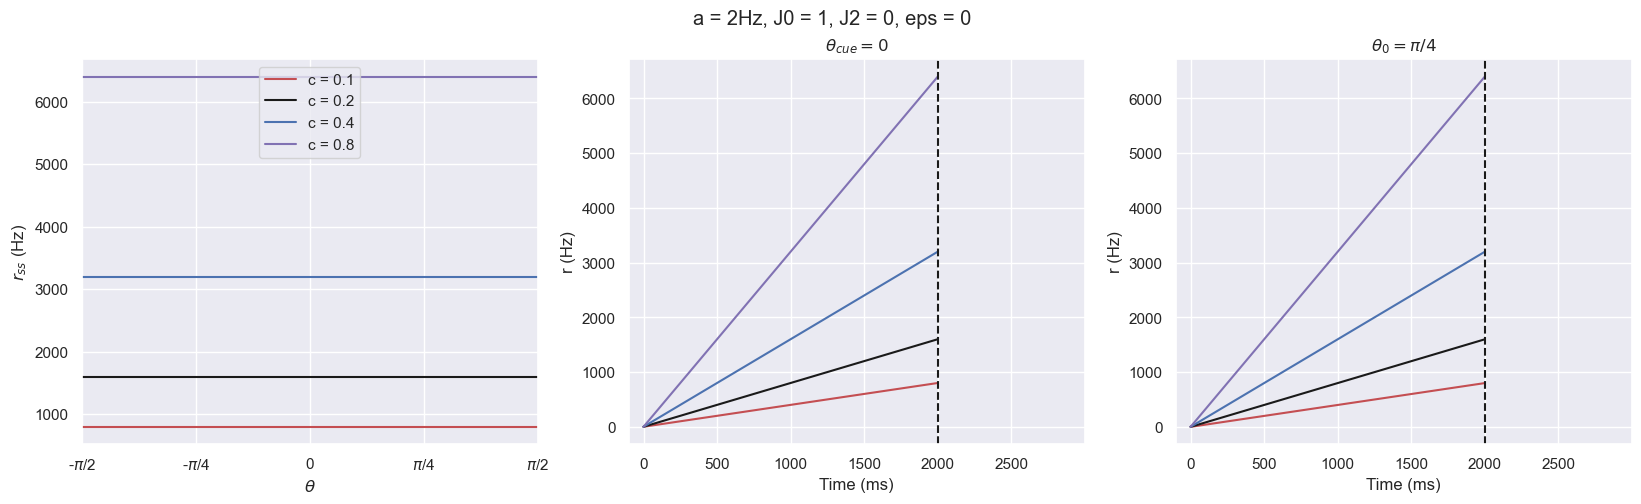

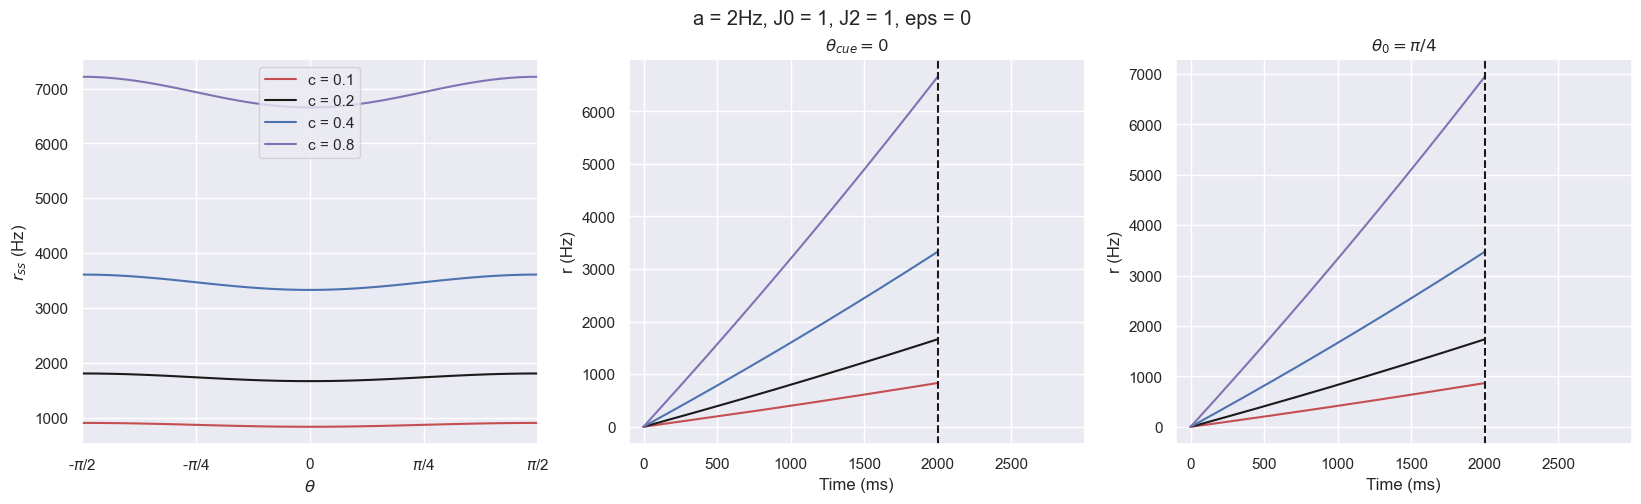

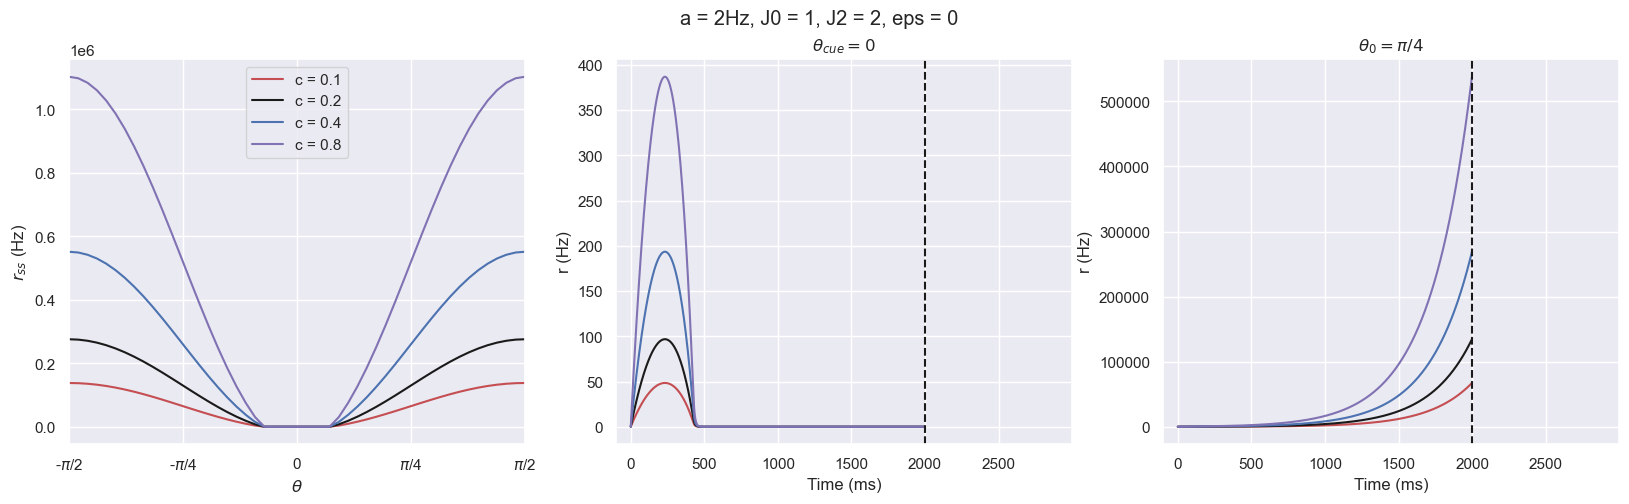

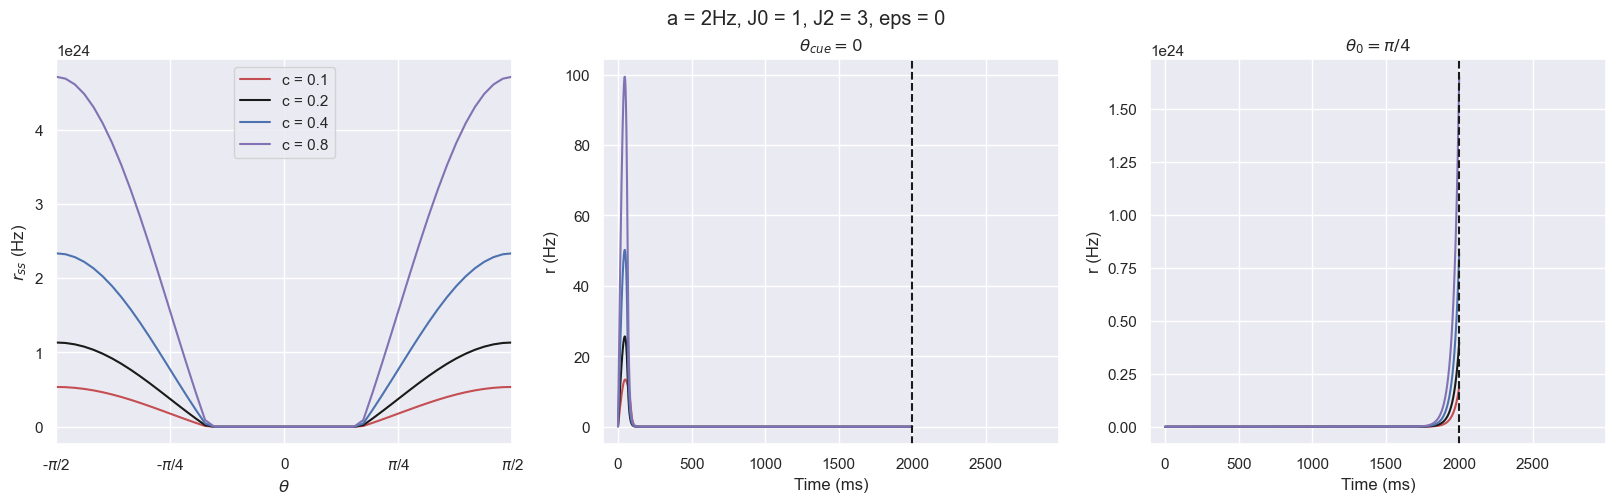

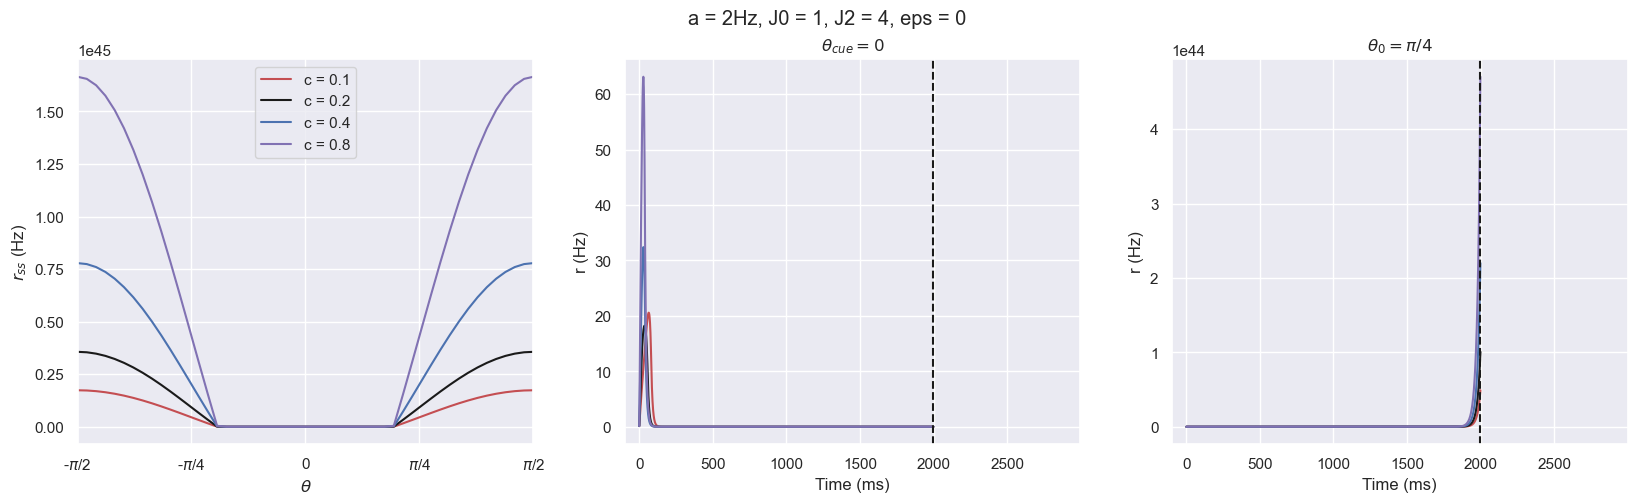

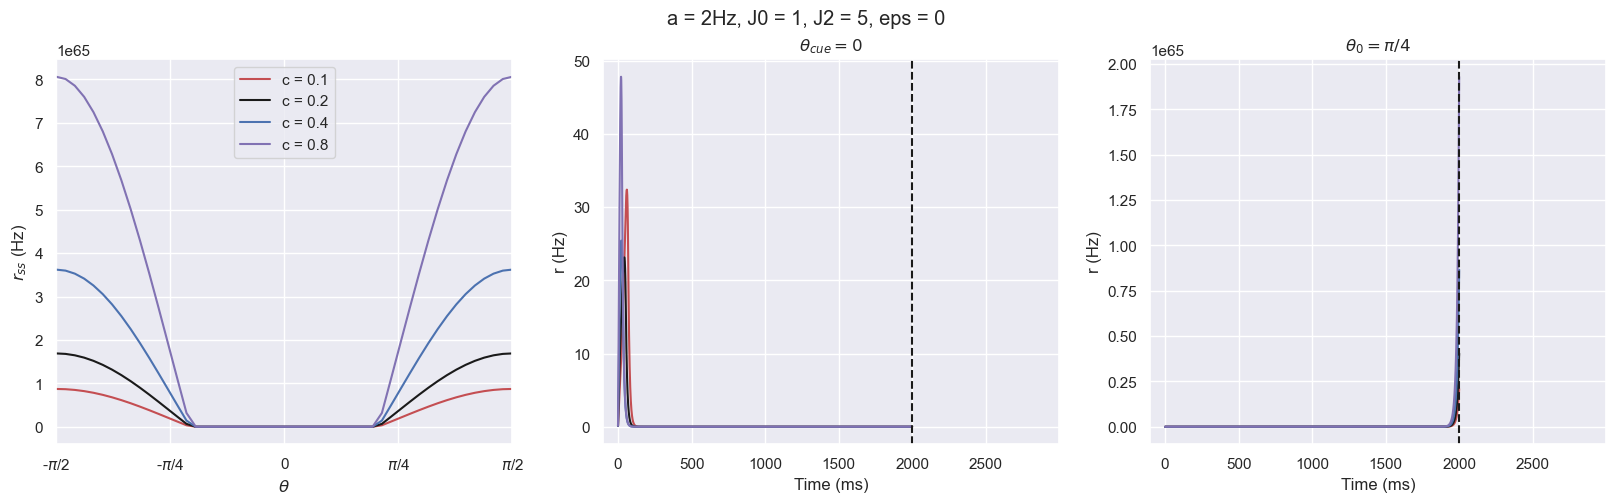

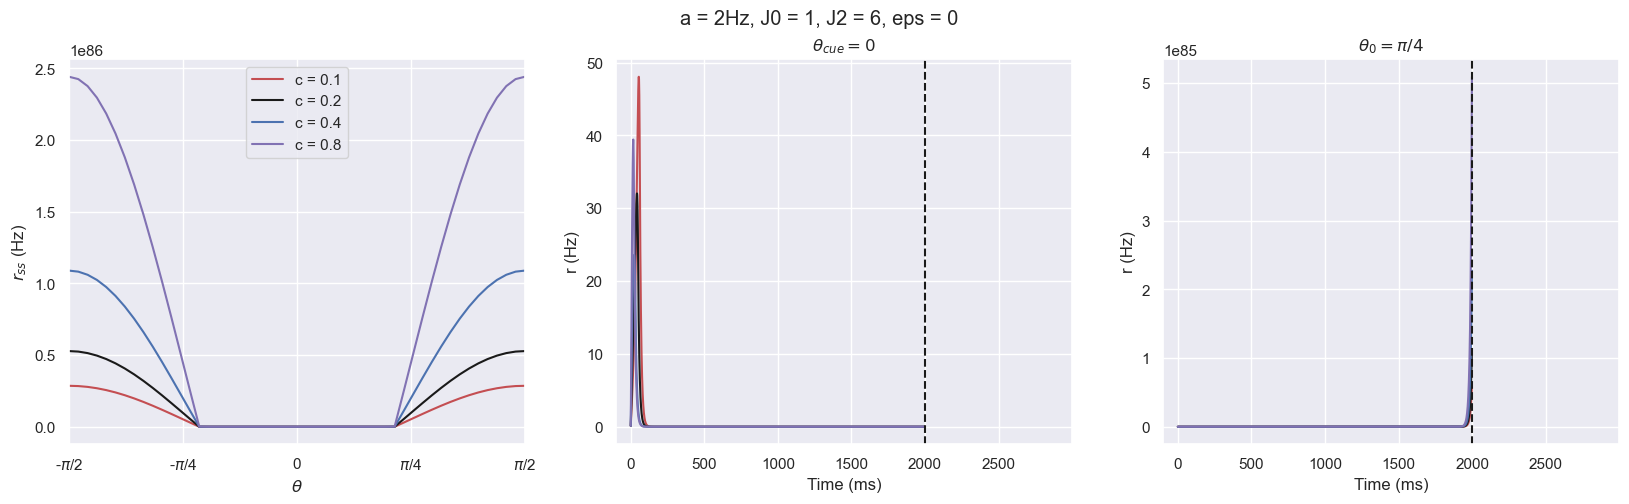

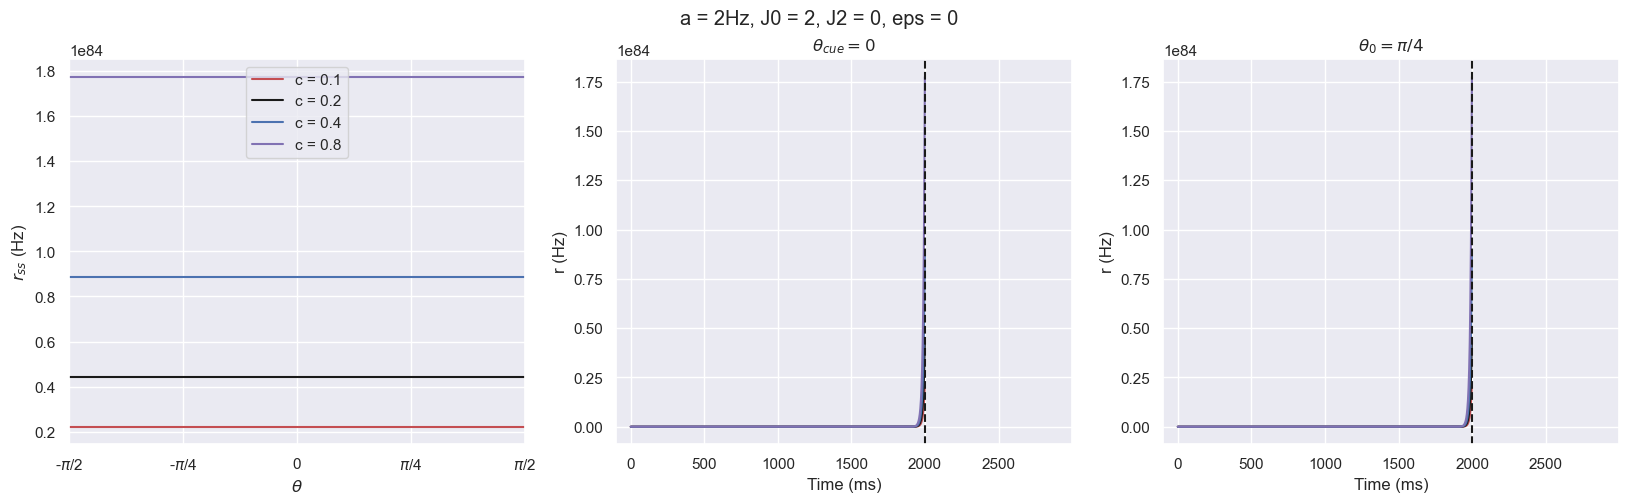

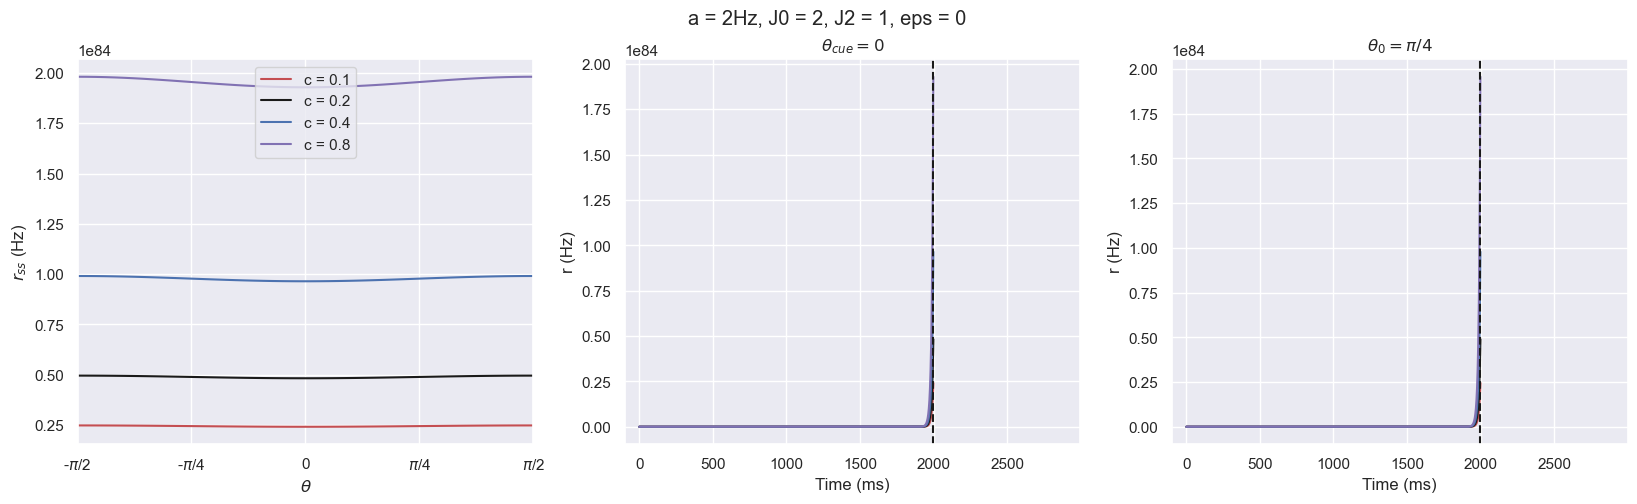

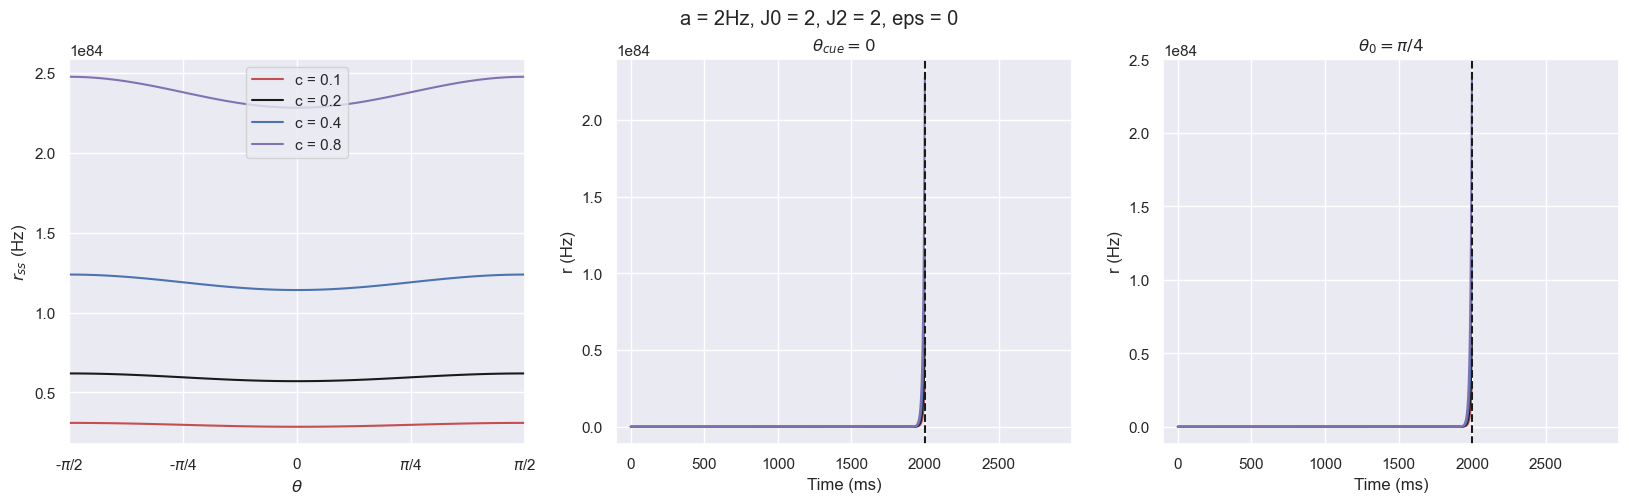

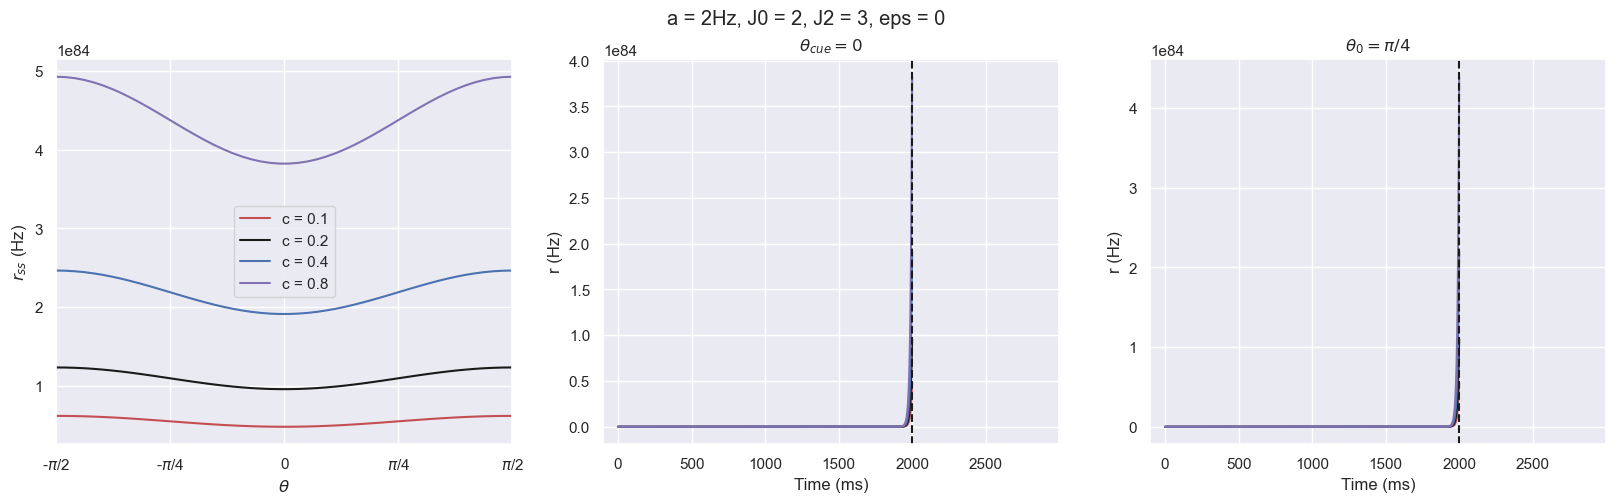

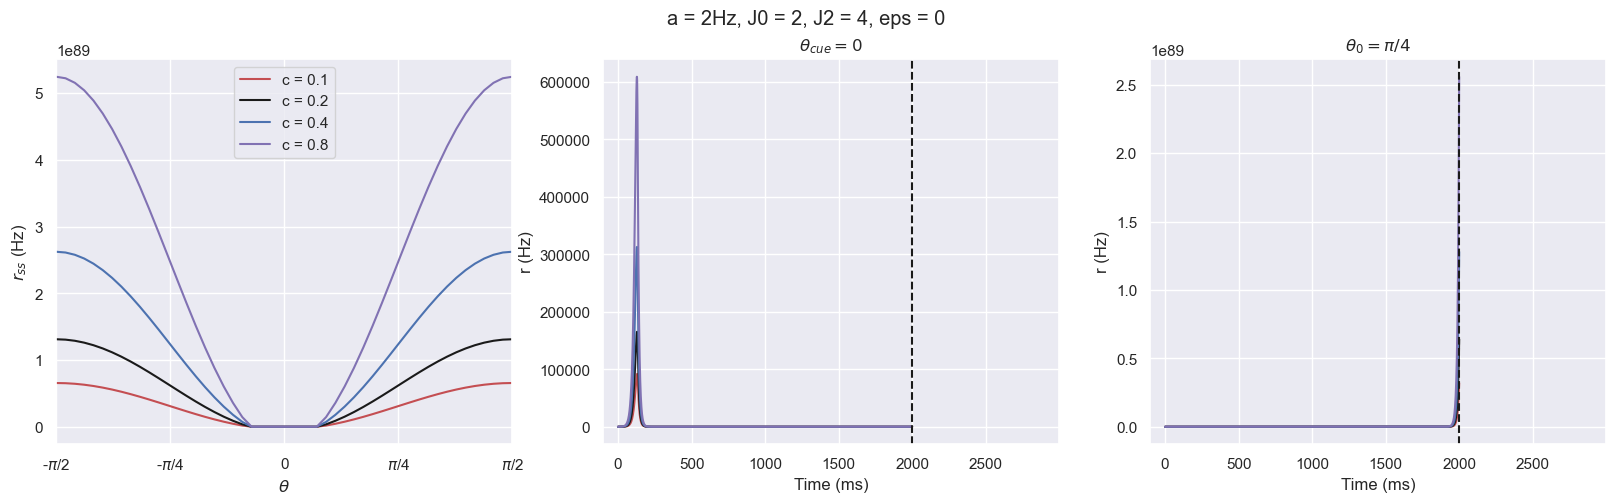

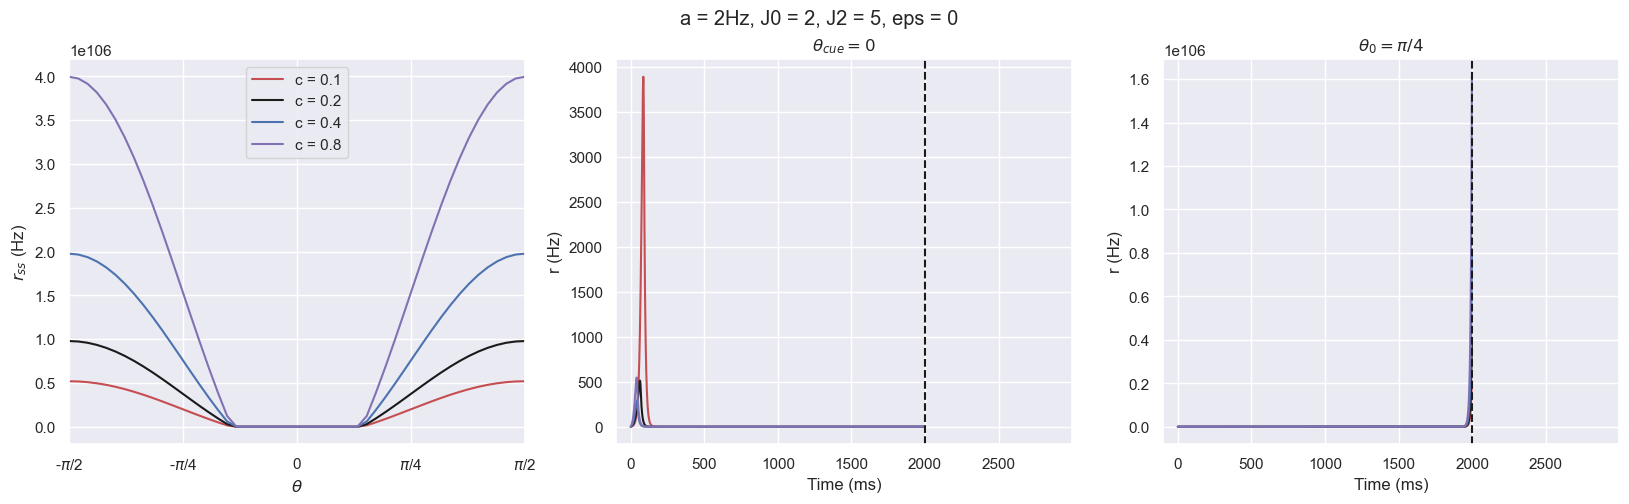

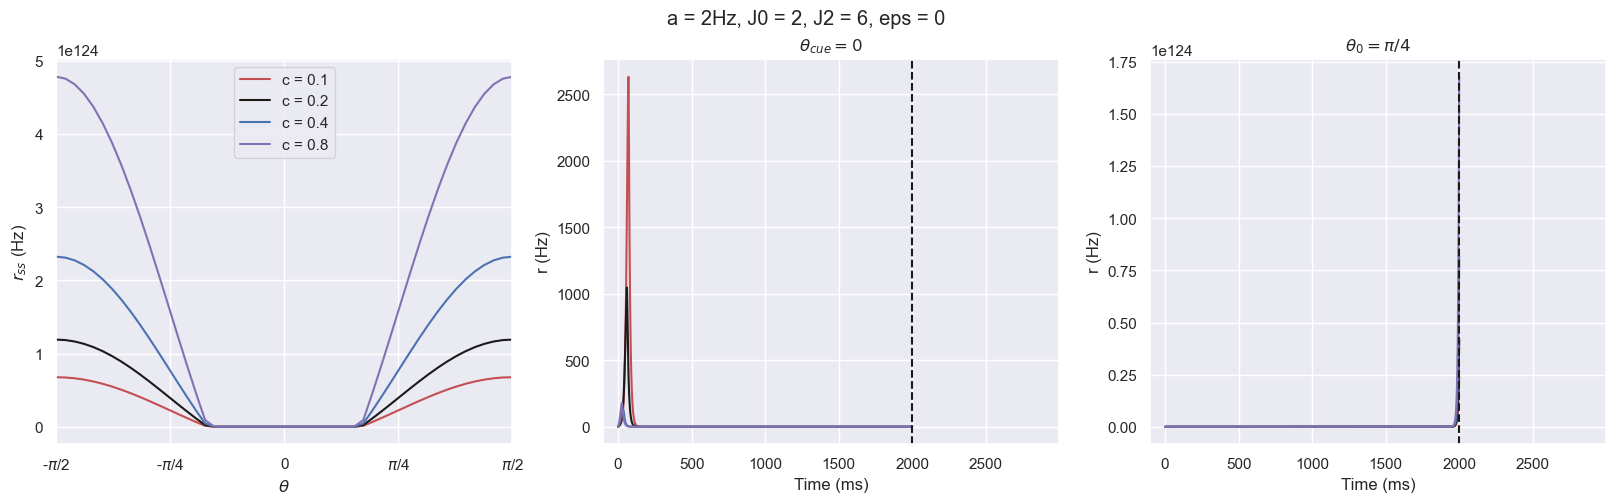

In [8]:
eps = 0
noisy = 0
noisiness_array = 3
J0_s = [-2, -1, 0, 1, 2]
J2_s = [0, 1, 2, 3, 4, 5, 6]

theta_0 = np.pi/4
theta_0_idx = abs(theta - theta_0).argmin()
a = 2/1000 # cycles/ms
r_master =  np.zeros((len(contrasts), len(theta), len(T)))
steady_state_time = np.zeros(len(contrasts), dtype = int)

for J0 in J0_s:
    for J2 in J2_s:
        second_term = recurrent_input(theta, J0, J2)
        for cc in range(len(contrasts)):
            c = contrasts[cc]
            h_theta = h(A, c, eps, theta, theta_cue)
            steady_state_time[cc], r_master[cc] = firing_rate(theta, theta_0, T, tau, del_t, a, h_theta, second_term, noisy, noisiness)
        plot_steady_state(theta, contrasts, r_master, steady_state_time, theta_cue_idx, theta_0, theta_0_idx, a, J0, J2, eps, noisy, noisiness)